# Capstone Breaking Bad

En este documento se puede observar el procedimiento llevado a cabo para hacer el estudio del descenso a la maldad de Walter White recogido en la siguiente memoria (para acceder a ella hacer click [aquí](https://drive.google.com/file/d/1GfQhcF_PSXh4YoGOVX8llep3wNrMgGai/view?usp=sharing)).

Los archivos utilizados en este proyecto se encuentran en una carpeta de acceso público llamada "Capstone Breaking Bad Cristina" (para acceder a ella hacer click [aquí](https://drive.google.com/drive/folders/1tRIzEQcqzemMrPFXmT-Cflfvg_NhX58T?usp=sharing))


## Importar librerías necesarias

In [70]:
!pip install openpyxl
!pip install nltk

In [71]:
import pandas as pd
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Funciones básicas de trabajo

In [72]:
def cargar_excel(filepath, sheet_name=0):
    df = pd.read_excel(filepath, sheet_name=sheet_name)
    return df

In [73]:
def guardar_excel(df, filepath):
    df.to_excel(filepath, index=False)
    print(f"Archivo Excel guardado en {filepath}")

## Generar archivo excel

Debido a la ausencia de un documento en internet que entregue las transcripciones completas de los diversos capítulos de Breaking Bad, se debe generar un nuevo archivo con el que trabajar.

Para generar este archivo se recogerá la información obtenida de la página ForeverDreaming (Para observarla hacer click [aquí](https://transcripts.foreverdreaming.org/viewforum.php?f=165)) en la que se encuentra el guión de cada capítulo, copiando dicho texto en diversos archivos de texto (.txt).

Dado que los guiones completos de las temporadas 4 y 5 no se pueden localizar en internet de forma que se diferencie qué personaje está hablando, se han utilizado los fragmentos de guión que se observan en la siguiente página web (link [aquí](https://en.wikiquote.org/wiki/Breaking_Bad_(season_4)#)) para comparar los dos archivos y añadir los nombres en el documento que contiene una mayor cantidad de nombres.

### Procesamiento de los txt que contienen los hablantes

Tras revisar los archivos txt, se ha observado un formato diferente en cada una de las opciones:
- Los archivos de ForeverDreaming (sin hablantes) muestran una oración por línea.
- Los archivos de WikiQuotes (con hablantes) muestran información de lo que está ocurriendo en escena entre corchetes [], el hablante al inicio de cada línea y varias frases separadas en ellas por interrogaciones (?), exclamaciones (!) y puntos (.).
Para poder generar el excel y comparar de forma adecuada los textos, se deberán realizar varios pasos que se organizan en pequeñas funciones.

#### Eliminación de anotaciones de escenas incluidas entre corchetes

La primera función se encarga de eliminar el texto entre corchetes, de manera que quitemos el ruido.

In [ ]:
def eliminar_corchetes(frase):
    frase = re.sub(r'\[.*?\]', '', frase) # Eliminar contenido entre corchetes
    return frase

#### Normalización inicial de las lineas a comparar

A continuación, se normaliza cada línea. Para ello se eliminan los signos de puntuación salvo los que indican cambio de frase (., ?, !), se convierte todo a minúsculas para facilitar la comparación entre las frases y se eliminan los espacios presentes antes y después del texto.

In [ ]:
def normalizar_frase(frase):
    frase = re.sub(r'[^a-zA-Z0-9\s\.\?\!]', '', frase) # Eliminar caracteres especiales excepto ., ?, !
    frase = frase.lower().strip()  # Convertir a minúsculas y eliminar espacios adicionales
    return frase

#### División de líneas en frases

Una vez normalizadas las líneas, se separan en frases utilizando los signos de puntuación observados y seleccionados anteriormente.

Este paso es fundamental para optimizar la comparación entre los textos y limpiar el documento.

In [ ]:
def dividir_frases_por_delimitadores(frase):
    frases = re.split(r'[.?!]', frase)  # Dividir por ., ? o !
    frases = [f.strip() for f in frases if len(f.strip()) > 0]  # Eliminar frases vacías
    return frases

Se diseña la función de procesamiento de texto en los archivos de WikiQuote (procesar_texto_con_hablantes()), incluyendo la eliminación de corchetes, la separación en líneas, su definición al mismo hablante, su división en frases y su almacenamiento en el diccionario que se utilizará para la comparativa.

Para tener un seguimiento del proceso, se añade una comprobación de los errores que indica en qué archivo y frase está ocurriendo el problema, permitiendo considerar si es un error aceptable (se eliminaría esa información igualmente en futuros procesamientos) o si es necesario revisar manualmente el error.

In [ ]:
def procesar_texto_con_hablantes(texto, nombre_archivo=None):
    texto = eliminar_corchetes(texto)  # Eliminar contenido entre corchetes
    lineas = texto.split("\n")  # Dividir en líneas
    frases_hablantes_dict = {}

    # Asignar el hablante a cada frase en la misma línea
    for linea in lineas:
        linea = linea.strip()
        if ":" in linea:  # Si hay un hablante definido
            hablante, frases_concatenadas = linea.split(":", 1)  # Separar "Hablante" y "Frases"
            frases_individuales = dividir_frases_por_delimitadores(frases_concatenadas)  # Dividir frases
            for frase in frases_individuales:
                frases_hablantes_dict[normalizar_frase(frase)] = hablante
        else:
          if nombre_archivo:
             print(f"Advertencia: Línea mal formateada o sin hablante explícito en el archivo '{nombre_archivo}': {frase}")

    return frases_hablantes_dict

Se diseña la función de procesamiento de texto en los archivos de ForeverDreaming (procesar_texto_sin_hablantes()), incluyendo la eliminación de corchetes, la separación en líneas, su división en frases y su almacenamiento en la lista que se utilizará para la comparativa.

In [ ]:
def procesar_texto_sin_hablantes(texto):
    texto = eliminar_corchetes(texto)  # Eliminar contenido entre corchetes
    lineas = texto.split("\n")  # Separar en líneas
    frases = []

    for linea in lineas:
        frases.extend(dividir_frases_por_delimitadores(linea))  # Dividir usando delimitadores
    return frases

Tras intentos anteriores de realizar la comparación con otras herramientas (*fuzzywuzzy* y *difflib*) que no entregan los resultados esperados, se diseña una función de comparación por n-gramas a través de Machine Learning utilizando la librería CountVectorizer.

In [ ]:
def calcular_similitud_ngram(frase1, frase2, n=3):
    # Verificar que ambas frases tengan un mínimo de caracteres válidos
    if len(frase1) < n or len(frase2) < n:
        return 0  # Similitud nula si las frases son demasiado cortas para n-gramas

    # Convertir frases a n-gramas
    vectorizador = CountVectorizer(analyzer='char', ngram_range=(n, n))
    try:
        ngramas = vectorizador.fit_transform([frase1, frase2])
    except ValueError:
        return 0  # Si el vocabulario está vacío, la similitud es nula

    # Calcular la similitud basada en los vectores de n-gramas
    similitud = np.dot(ngramas[0].toarray(), ngramas[1].toarray().T)[0][0]
    return similitud

Para simplificar el trabajo de revisión de comparaciones, se establece un nivel de compromiso en la similitud, de manera que si es más del 50% se considerará una aplicación correcta y si se encuentra entre el 30% y el 50% se deberá revisar de manera manual para decidir si es adecuada.

In [ ]:
def revisar_coincidencias(similitud, umbral_revision=0.75):
    if umbral_revision > similitud >= 0.5:  # Si la similitud es intermedia, marcar para revisión
        return "Revisar"
    else:
        return "Correcta"

Se diseña la función principal, añadiendo pequeños puntos de control para reconocer la evolución de este procesamiento.

In [ ]:
def comparar_archivos_con_ngramas(carpeta_base, carpeta_hablantes, archivo_salida):
    archivos_base = set(os.listdir(carpeta_base))
    archivos_hablantes = set(os.listdir(carpeta_hablantes))
    archivos_comunes = archivos_base.intersection(archivos_hablantes)

    with pd.ExcelWriter(archivo_salida, engine='openpyxl') as writer:
        hoja_creada = False
        for nombre_archivo in archivos_comunes:
            if nombre_archivo.endswith(".txt"):
                print(f"Procesando archivo: {nombre_archivo}")

                ruta_archivo_base = os.path.join(carpeta_base, nombre_archivo)
                ruta_archivo_hablantes = os.path.join(carpeta_hablantes, nombre_archivo)

                try:
                    with open(ruta_archivo_base, 'r', encoding='utf-8') as f:
                        texto_base = f.read()
                    with open(ruta_archivo_hablantes, 'r', encoding='utf-8') as f:
                        texto_hablantes = f.read()

                    # Procesar los textos en frases
                    frases_base = procesar_texto_sin_hablantes(texto_base)
                    frases_hablantes_dict = procesar_texto_con_hablantes(texto_hablantes)

                    # Depurar el tamaño de frases base
                    print(f"Archivo: {nombre_archivo}, Total de frases en base: {len(frases_base)}")

                    # Verificar si "frases_base" está vacío antes de continuar
                    if not frases_base:
                        print(f"Advertencia: El archivo '{nombre_archivo}' no tiene frases base válidas.")
                        df_vacio = pd.DataFrame({
                            "Frase": ["Archivo vacío o sin frases válidas"],
                            "Frase_Coincidente": ["Sin coincidencia"],
                            "Similitud (%)": [0],
                            "Hablante": ["Ausente"],
                            "Revisión": ["Revisar"]
                        })
                        df_vacio.to_excel(writer, sheet_name=os.path.splitext(nombre_archivo)[0], index=False)
                        continue

                    if not frases_hablantes_dict:
                        print(f"Advertencia: El archivo '{nombre_archivo}' no tiene frases con hablantes válidas.")
                        df_vacio = pd.DataFrame({
                            "Frase": frases_base,
                            "Frase_Coincidente": ["Sin coincidencia"] * len(frases_base),
                            "Similitud (%)": [0] * len(frases_base),
                            "Hablante": ["Ausente"] * len(frases_base),
                            "Revisión": ["Revisar"] * len(frases_base)
                        })
                        df_vacio.to_excel(writer, sheet_name=os.path.splitext(nombre_archivo)[0], index=False)
                        continue

                    # Realizar la comparación para cada frase del archivo base usando n-gramas
                    comparaciones = []
                    for i, frase in enumerate(frases_base):
                        print(f"Comparando frase {i+1}/{len(frases_base)} del archivo '{nombre_archivo}'")  # Depurar el índice de cada frase

                        # Normalizar y calcular las coincidencias usando n-gramas
                        try:
                            similitudes = [(frase_objetivo, calcular_similitud_ngram(frase, frase_objetivo)) for frase_objetivo in frases_hablantes_dict.keys()]
                            similitudes.sort(key=lambda x: x[1], reverse=True)
                        except Exception as sim_e:
                            print(f"Error calculando la similitud para la frase '{frase}' en el archivo '{nombre_archivo}': {sim_e}")
                            continue  # Pasar a la siguiente frase si hay un problema

                        # Tomar la frase con mayor similitud
                        if similitudes and similitudes[0][1] > 0:
                            frase_coincidente, similitud = similitudes[0]
                        else:
                            frase_coincidente, similitud = "Sin coincidencia", 0

                        # Si la similitud es alta (>= 0.5), asignar el hablante; de lo contrario, marcar como "Ausente"
                        hablante = frases_hablantes_dict.get(frase_coincidente, "Ausente") if similitud >= 0.75 else "Ausente"

                        # Determinar si la coincidencia requiere revisión
                        revision = revisar_coincidencias(similitud)

                        # Almacenar la frase original, la coincidencia, la puntuación y el hablante
                        comparaciones.append({
                            "Frase": frase,
                            "Frase_Coincidente": frase_coincidente,
                            "Similitud (%)": round(similitud * 100, 2),
                            "Hablante": hablante,
                            "Revisión": revision
                        })

                    # Crear el DataFrame y añadirlo como pestaña en el archivo Excel
                    if comparaciones:
                        df_comparaciones = pd.DataFrame(comparaciones)
                        nombre_pestana = os.path.splitext(nombre_archivo)[0]
                        df_comparaciones.to_excel(writer, sheet_name=nombre_pestana, index=False)
                        hoja_creada = True
                        print(f"Pestaña '{nombre_pestana}' generada en el archivo Excel '{archivo_salida}'.")

                except Exception as e:
                    print(f"Error procesando archivo '{nombre_archivo}': {e}")

        if not hoja_creada:
            pd.DataFrame({"Info": ["No se generaron coincidencias válidas"]}).to_excel(writer, sheet_name="Control")

    print(f"Archivo Excel '{archivo_salida}' generado exitosamente con todas las pestañas.")

Librerías específicas para poder ejecutar el código y generar el archivo posteriormente.

In [ ]:
import pandas as pd
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [ ]:
# Definir las rutas de las carpetas
carpeta_base = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_4y5"  # Carpeta con archivos base (solo frases)
carpeta_hablantes = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_4y5_Personajes"  # Carpeta con archivos de hablantes (diálogos con personajes)
archivo_salida = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/comparacion_multiple.xlsx"  # Carpeta de salida para los archivos Excel generados

# Ejecutar la comparación y generación de un único archivo Excel
comparar_archivos_con_ngramas(carpeta_base, carpeta_hablantes, archivo_salida)

Se han truncado las últimas 5000 líneas del flujo de salida.
Comparando frase 98/757 del archivo 's05e13.txt'
Comparando frase 99/757 del archivo 's05e13.txt'
Comparando frase 100/757 del archivo 's05e13.txt'
Comparando frase 101/757 del archivo 's05e13.txt'
Comparando frase 102/757 del archivo 's05e13.txt'
Comparando frase 103/757 del archivo 's05e13.txt'
Comparando frase 104/757 del archivo 's05e13.txt'
Comparando frase 105/757 del archivo 's05e13.txt'
Comparando frase 106/757 del archivo 's05e13.txt'
Comparando frase 107/757 del archivo 's05e13.txt'
Comparando frase 108/757 del archivo 's05e13.txt'
Comparando frase 109/757 del archivo 's05e13.txt'
Comparando frase 110/757 del archivo 's05e13.txt'
Comparando frase 111/757 del archivo 's05e13.txt'
Comparando frase 112/757 del archivo 's05e13.txt'
Comparando frase 113/757 del archivo 's05e13.txt'
Comparando frase 114/757 del archivo 's05e13.txt'
Comparando frase 115/757 del archivo 's05e13.txt'
Comparando frase 116/757 del archivo 's05


Los guiones de las primeras tres temporadas se unirán en una misma hoja de cálculo que separe en dos columnas los personajes que hablan (Hablante) y las frases que dice (Frase) utilizando el siguiente código:

In [ ]:
ruta_carpeta = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_1a3"
archivo_salida = r"/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_breaking_bad.xlsx"

hojas_dict = {}
archivos_txt = [f for f in os.listdir(ruta_carpeta) if f.endswith(".txt")]

for archivo in archivos_txt:
    with open(os.path.join(ruta_carpeta, archivo), "r", encoding="utf-8") as f:
        lineas = f.readlines()

    data = []
    for linea in lineas:
        if ": " in linea:
            hablante, frase = linea.split(": ", 1)
            data.append({"Hablante": hablante.strip(), "Frase": frase.strip()})

    df = pd.DataFrame(data)

    nombre_hoja = os.path.splitext(archivo)[0]
    hojas_dict[nombre_hoja] = df

with pd.ExcelWriter(archivo_salida, engine='openpyxl') as writer:
    for nombre_hoja, dataframe in hojas_dict.items():
        dataframe.to_excel(writer, sheet_name=nombre_hoja, index=False)

print(f"Archivo Excel '{archivo_salida}' creado exitosamente con {len(hojas_dict)} pestañas.")

Archivo Excel '/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_breaking_bad.xlsx' creado exitosamente con 33 pestañas.


Se unen ambos excel para tener una única base de datos.

In [ ]:
def combinar_excels(archivo_anterior, archivo_nuevo, archivo_combinado):
    libro_anterior = pd.read_excel(archivo_anterior, sheet_name=None)  # Cargar todas las hojas del archivo anterior
    libro_nuevo = pd.read_excel(archivo_nuevo, sheet_name=None)  # Cargar todas las hojas del archivo nuevo

    # Crear un "pd.ExcelWriter" para combinar ambos libros
    with pd.ExcelWriter(archivo_combinado, engine='openpyxl') as writer:
        # Escribir todas las hojas del archivo anterior
        for nombre_hoja, df in libro_anterior.items():
            df.to_excel(writer, sheet_name=nombre_hoja, index=False)

        # Escribir todas las hojas del archivo nuevo
        for nombre_hoja, df in libro_nuevo.items():
            df.to_excel(writer, sheet_name=nombre_hoja, index=False)

    print(f"Archivo combinado generado exitosamente: {archivo_combinado}")

In [ ]:
# Definir las rutas de los archivos
archivo_anterior = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_breaking_bad.xlsx"
archivo_nuevo = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/comparacion_multiple.xlsx"  # Carpeta de salida para los archivos Excel generados
archivo_combinado = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/archivo_combinado_final.xlsx"

# Ejecutar la combinación de ambos archivos
combinar_excels(archivo_anterior, archivo_nuevo, archivo_combinado)

Archivo combinado generado exitosamente: /content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/archivo_combinado_final.xlsx


## Procesar el archivo excel para facilitar su uso

En esta sección se procederá a modificar el archivo excel conjunto para simplificar el uso y permitir el preprocesamiento de los datos de forma eficaz.

Los pasos serán:
- Ordenar las pestañas teniendo en cuenta el orden de la serie.
- Sustituir las palabras censuradas de los scripts con asteriscos (*) o ausencia de letras en su escritura con las palabras originales.

### Orden de pestañas y creación columnas Temporada y Episodio

La primera función es "parse_sheet_name" que, aprovechando que al generar el archivo .txt se nombró siguiendo la estructura "s00e00", se puede separar sencillamente en "Temporada" y "Episodio".

In [ ]:
def parse_sheet_name(sheet_name):
    try:
        temporada = int(sheet_name[1:3])
        episodio = int(sheet_name[4:6])
        return temporada, episodio
    except Exception as e:
        raise ValueError(f"Error al analizar el nombre de la pestaña: {sheet_name}. Error: {e}")

La segunda función, "sort_key", está diseñada para que las pestañas que incluyen los episodios se ordenen por temporada y capítulo.

In [ ]:
def sort_key(sheet_name):
    try:
        temporada, episodio = parse_sheet_name(sheet_name)
        return (temporada, episodio)
    except ValueError:
        return (float('inf'), float('inf'))

A continuación, se diseña una función "load_and_save_excel" para ordenar las pestañas, añadir las columnas de Temporada y Episodio, y seleccionar las columnas de Hablante y Frase para generar el excel final.

In [ ]:
def load_and_save_excel(filepath, output_filepath):
    try:
        df = pd.read_excel(filepath, index_col=None, header=None, sheet_name=None)
        dfs_dict = {}

        for sheet_name, df_sheet in df.items():
            if df_sheet.empty:
                continue

            try:
                temporada, episodio = parse_sheet_name(sheet_name)
            except ValueError:
                print(f"Formato inesperado en el nombre de la pestaña: {sheet_name}. Saltando esta pestaña.")
                continue

            # Verificar el número de columnas para determinar el tipo de estructura
            if df_sheet.shape[1] == 2:
                # Si tiene solo 2 columnas, asumir que son Hablante y Frase
                df_sheet.columns = ["Hablante", "Frase"]
            elif df_sheet.shape[1] == 5:
                # Si tiene 5 columnas, seleccionar solo Hablante y Frase
                df_sheet = df_sheet.iloc[:, [3, 0]]
                df_sheet.columns = ["Hablante", "Frase"]
            else:
                print(f"Formato de datos inesperado en la pestaña {sheet_name}. Número de columnas: {df_sheet.shape[1]}. Saltando.")
                continue


            df_sheet = df_sheet.iloc[1:].reset_index(drop=True)

            df_sheet['Temporada'] = temporada
            df_sheet['Episodio'] = episodio

            df_sheet = df_sheet[['Temporada', 'Episodio', 'Hablante', 'Frase']]

            dfs_dict[sheet_name]= df_sheet

        ordered_sheets = sorted(dfs_dict.items(), key=lambda x: sort_key(x[0]))

        with pd.ExcelWriter(output_filepath, engine='openpyxl') as writer:
            for sheet_name, df_sheet in ordered_sheets:
                df_sheet.to_excel(writer, sheet_name=sheet_name, index=False)

        print(f"Archivo Excel '{output_filepath}' actualizado exitosamente con las nuevas columnas.")

    except ValueError as e:
        print(f'Error de formato del archivo Excel: {e}')
        return None
    except FileNotFoundError as e:
        print(f'Error al encontrar el archivo: {e}')
        return None
    except pd.errors.ParserError as e:
        print(f'Error al analizar el archivo Excel: {e}')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo: {e}')
        return None

Se ejecutan los códigos para obtener un archivo básico con el que trabajar de forma local/manual para los últimos detalles.

In [ ]:
input_filepath= "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/archivo_combinado_final.xlsx"
output_filepath= "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_breaking_bad_ordenado.xlsx"

load_and_save_excel(input_filepath, output_filepath)

Archivo Excel '/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_breaking_bad_ordenado.xlsx' actualizado exitosamente con las nuevas columnas.


## Preprocesamiento de los datos

### Agrupar todos los capítulos en la misma pestaña para facilitar el trabajo al programa

Se decide generar un nuevo archivo .xlsx en el que todos los valores se encuentren en la misma pestaña para simplificar su trabajo y estudio por la computadora.

In [ ]:
def combine_excel_sheets(file_path):
    """
    Combina todas las hojas de un archivo Excel en un solo DataFrame.
    """
    sheets_dict = pd.read_excel(file_path, sheet_name=None)
    df_combinado = pd.concat(sheets_dict.values(), ignore_index=True)
    return df_combinado

In [ ]:
def verify_columns(df, required_columns):
    """
    Verifica si las columnas requeridas están presentes en el DataFrame.
    """
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Error: Las siguientes columnas faltan en el DataFrame: {missing_columns}")
        return False
    return True

In [ ]:
def analyze_by_season_and_episode(df):
    """
    Realiza el análisis por Temporada y por Temporada-Episodio.
    """
    # Análisis básico por Temporada
    resumen_temporada = df.groupby(['Temporada']).agg({'Frase': 'count'}).reset_index()
    resumen_episodio = df.groupby(['Temporada', 'Episodio']).agg({'Frase': 'count'}).reset_index()

    return resumen_temporada, resumen_episodio

In [ ]:
def combinar_hojas_y_primer_resumen():
    # Definir la ruta del archivo de diálogos
    archivo_dialogos = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_breaking_bad_ordenado.xlsx"
    output_filepath = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_combinados_unapag.xlsx"

    # 1. Combinar las hojas en un solo DataFrame
    df_combinado = combine_excel_sheets(archivo_dialogos)

    # 2. Guardar el DataFrame combinado en un nuevo archivo Excel
    df_combinado.to_excel(output_filepath, index=False)
    print(f"Archivo Excel '{output_filepath}' generado exitosamente con las hojas agrupadas en una sola página.")

    # 3. Verificar que las columnas necesarias existan antes de continuar
    columnas_requeridas = ['Temporada', 'Episodio', 'Frase']
    if not verify_columns(df_combinado, columnas_requeridas):
        return  # Terminar ejecución si las columnas no están presentes

    # 4. Realizar el análisis por Temporada y Episodio
    resumen_temporada, resumen_episodio = analyze_by_season_and_episode(df_combinado)

    # 5. Mostrar análisis básico por Temporada
    print("Análisis por Temporada:")
    print(resumen_temporada)
    print("Análisis por Temporada y Episodio:")
    print(resumen_episodio)

In [ ]:
combinar_hojas_y_primer_resumen()

Archivo Excel '/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_combinados_unapag.xlsx' generado exitosamente con las hojas agrupadas en una sola página.
Análisis por Temporada:
   Temporada  Frase
0          1   1814
1          2   3126
2          3   3078
3          4   6972
4          5  10248
Análisis por Temporada y Episodio:
    Temporada  Episodio  Frase
0           1         1    320
1           1         2    193
2           1         3    238
3           1         4    199
4           1         5    265
..        ...       ...    ...
57          5        12    601
58          5        13    757
59          5        14    695
60          5        15    634
61          5        16    478

[62 rows x 3 columns]


### Modificación de palabras censuradas en el documento

Se genera un diccionario con el que modificar la versión censurada de las palabras malsonantes o demasiado fuertes con la palabra original y se limpia el documento.

In [ ]:
def eliminar_censura_y_normalizacion_frases(df):
    df['Frase'] = df['Frase'].str.lower()
    df['Frase'] = df['Frase'].str.strip()
    df['Frase'] = df['Frase'].str.replace(r'[^\w\s]', '', regex=True)
    replace_dict = {
    'gn' : 'gun',
    'motherfer' : 'motherfucker',
    'glck' : 'gun',
    'sht' : 'shot',
    'shts' :'shots',
    'fck' : 'fuck',
    'fcking' : 'fucking',
    'dck' : 'dick',
    'kll' : 'kill',
    'bmb': 'bomb',
    'fggt': 'faggot',
    'hm': 'homo',
    'gddmn' : 'goddamn',
    'mrder': 'murder',
    'volence': 'violence',
    'wapon': 'weapon',
    'btch': 'bitch',
    'thraten': 'threaten',
    'kller': 'killer',
    'klled' : 'killed',
    'rtarded': 'retarded',
    'shtting': 'shootting',
    'asshle': 'asshole',
    'bllet': 'bullet',
    'pssy': 'pussy',
    'explsin': 'explosion',
    'explsives': 'explosives',
    'baner': 'beaner',
    'mtherfucker': 'motherfucker',
    'retrded': 'retarded',
    'explsin': 'explosion',
    'drgs': 'drugs',
    'wr': 'war',
    'bstards': 'bastards',
    'murderd': 'murdered',
    'hackercrcker': 'hackercracker',
    'shot': 'shoot',
    'atmatic': 'automatic',
    'attcked': 'attacked',
    'gunshitt': 'gunshot',
    'bllts': 'bullets',
    'asault': 'assault',
    'tnk': 'tank',
    'murderr': 'murderer',
    'anl': 'anal',
    'crpple': 'cripple',
    'explsive': 'explosive',
    'snper': 'sniper',
    'pstol': 'pistol',
    'trture': 'torture',
    'nzi': 'nazi',
    'rped': 'raped',
    'af': 'atf',
    'attcks': 'attacks',
    'attillery': 'artillery',
    'rtard': 'retard',
    'rfle': 'rifle',
    'chnk': 'chink',
    'gungbng': 'gungbang'
    }

    # Aplicar las sustituciones
    df['Frase'] = df['Frase'].replace(replace_dict)

    return df

In [ ]:
def limpieza_texto_final():
    # Definir la ruta del archivo de entrada y salida
    input_filepath = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_combinados_unapag.xlsx"
    output_filepath = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_limpios.xlsx"

    # Cargar el Excel como DataFrame
    df = cargar_excel(input_filepath)

    # Eliminar censura y normalizar frases
    df_limpio = eliminar_censura_y_normalizacion_frases(df)

    # Guardar el DataFrame resultante
    guardar_excel(df_limpio, output_filepath)

limpieza_texto_final()

Archivo Excel guardado en /content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_limpios.xlsx


### Preprocesamiento de los personajes

#### Limpiar los nombres de los personajes

Al revisar con .unique() los personajes que aparecen en el excel, se puede observar la **presencia de alias, errores de ortografía y variaciones en los nombres de los personajes** que dificultarían el estudio. Para solventar este problema se debe normalizar los datos.  

In [ ]:
# Cargar el archivo
filepath = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_limpios.xlsx"
df = cargar_excel(filepath)

# Obtener los nombres de los hablantes únicos y ordenarlos alfabéticamente
unique_hablantes = sorted(df["Hablante"].unique())

# Mostrar los nombres en orden alfabético
unique_hablantes

['Administrator',
 'Agent',
 'Andrea',
 'Andrew',
 'Answering Machine',
 'Antonio',
 'Ausente',
 'Badger',
 'Barry',
 'Bartender',
 'Ben',
 'Benicio',
 'Benicio Fuentes',
 'Biker',
 'Bobby',
 'Bogdan',
 'Bolsa',
 'Both',
 'Brock',
 'Buyer',
 'Cara',
 'Carmen',
 'Chad',
 'Chad’s Girlfriend',
 'Charlie',
 'Charlie Rose',
 'Chow',
 'Clovis',
 'Combo',
 'Commercial Guy #1',
 'Commercial Guy #2',
 'Cop',
 'Counselor',
 'Coworker',
 'Customer',
 'Cynthia',
 'Dealer',
 'Declan',
 'Doctor',
 'Donald',
 'Dr. Bravenec',
 'Dr. Delcavoli',
 'Driver',
 'Drug Dealer',
 'EMT',
 'Ed',
 'Eladio',
 'Elliott',
 'Emilio',
 'Employee',
 'Everyone',
 'Farley',
 'Francesca',
 'Friend',
 'Friend #2',
 'Gale',
 'Gary',
 'George Merkert',
 'Girl Cop',
 'Gomez',
 'Gonzo',
 'Grandma',
 'Gretchen',
 'Group',
 'Group Leader',
 'Gus',
 'Gustavo',
 'Guy',
 'Hank',
 'Hank Schrader',
 'Hank(on the news)',
 'Hector',
 'Homeless Man',
 'Huell',
 'Hugo',
 'Intercom',
 'Jack',
 'Jake',
 'James',
 'Jane',
 'Janet',
 'Jane’s

Para llevar a cabo la normalización se ha **generado de manera manual un diccionario** en el cual se unifican los nombres al sustituirlos por un único valor, se han **pasado a minúscula** y se han **eliminado caracteres especiales y los espacios en blanco antes y después de las palabras**.

Además, se aprovechará esta función para **eliminar las categorías irrelevantes** ("scene" y "ausente").

In [ ]:
def normalizar_y_limpiar_personajes(df):
    df['Hablante'] = df['Hablante'].astype(str)
    df['Hablante'] = df['Hablante'].str.lower().str.strip()
    df['Hablante'] = df['Hablante'].str.replace(r'[^\w\s]', '', regex=True)
    replace_dict = {
    'answering machine' :'ausente',
    'benicio fuentes' : 'benicio',
    'bobby' : 'ausente',
    'charlie rose' : 'charlie',
    'george merkert' : 'merkert',
    'girl gop' : 'cop',
    'gustavo' : 'gus',
    'hank schrader' : 'hank',
    'hankon the news': 'hank',
    'janes voicemail': 'jane',
    'jesseanswering machine': 'jesse',
    'kaylie' : 'kailee',
    'merket': 'merkert',
    'olive oil' : 'ausente',
    'real estate agent': 'realtor',
    'reporteron the news': 'reporter',
    'scene': 'ausente',
    'skyler walts imagination': 'skyler',
    'walt jr': 'walter jr',
    'walter junior': 'walter jr',
    'walt': 'walter',
    'walteranswering machine' : 'walter',
    }


    # Aplicar las sustituciones
    df['Hablante'] = df['Hablante'].replace(replace_dict)

    # Eliminar categorías irrelevantes
    df = df[~df['Hablante'].isin(['ausente', 'scene'])]
    return df

#### Creamos la función para seleccionar los personajes principales

In [ ]:
def filtrar_pj_principales(df, min_lines=50):
    """
    Filtra los personajes principales del DataFrame según el umbral de número de líneas.
    Args:
        df (pd.DataFrame): DataFrame con la columna 'Hablante'.
        min_lines (int): Umbral de número de líneas para considerar un personaje como principal.
    Returns:
        pd.DataFrame: DataFrame con solo los personajes principales.
    """
    main_characters = df['Hablante'].value_counts()
    main_characters = main_characters[main_characters >= min_lines].index
    return df[df['Hablante'].isin(main_characters)]

#### Creamos una función base para procesar los personajes que será la que modifiquemos y ampliemos en caso de necesidad.

In [ ]:
def procesar_personajes(df, min_lines=50):
    """
    Función principal para organizar el flujo de limpieza y procesamiento de personajes.
    Args:
        df (pd.DataFrame): DataFrame con las columnas originales.
        min_lines (int): Umbral de número de líneas para considerar un personaje como principal.
    Returns:
        pd.DataFrame: DataFrame final con personajes procesados y codificados.
    """
    # 1. Normalizar y limpiar los nombres de los personajes
    df = normalizar_y_limpiar_personajes(df)
    # 2. Filtrar los personajes principales según el umbral de líneas
    df = filtrar_pj_principales(df, min_lines=min_lines)

    return df

#### Creación de una función para lanzar la limpieza de los datos de los personajes

Se diseña y ejecuta la función en la que se incluirán las direcciones y procesos que se llevarán a cabo la limpieza previamente generada.

Al final de este paso se genera un nuevo archivo excel intermedio que se nombra como "dialogosypersonajes_limpios"

In [ ]:
def procesar_personajes_limpios():
    # Definir las rutas de los archivos de entrada y salida
    input_filepath = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogos_limpios.xlsx"
    output_filepath = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogosypersonajes_limpios.xlsx"

    # Cargar los datos del archivo Excel
    df = cargar_excel(input_filepath)

    # Procesar los personajes con el flujo de trabajo
    df_procesado = procesar_personajes(df, min_lines=50)

    # Guardar el resultado en un nuevo archivo Excel
    guardar_excel(df_procesado, output_filepath)

procesar_personajes_limpios()

Archivo Excel guardado en /content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogosypersonajes_limpios.xlsx


### Preprocesamiento del resto de los datos

#### Creación de funciones para preprocesar el texto (que incluye tokenización, lematización y eliminación de stopwords y fillerwords)

Se establecen las stopwords y fillerwords a eliminar y se inicia la carga del lematizador

In [ ]:
# Inicializar el lematizador y la lista de stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Lista personalizada de fillerwords
fillerwords = {"like", "well", "actually", "basically", "you know", "uh", "um", "hmm", "so", "just"}

Se estable una función para preprocesar el texto de la columna "Frase" y otra para preprocesar los diccionarios.

Se realiza el mismo preprocesamiento de texto para las palabras clave que establecen las categorias del estudio y las palabras presentes en el texto para facilitar y mejorar el análisis realizado por la computadora.

In [ ]:
def preprocess_text(text):
    """
    Función para preprocesar un texto: normalizar, tokenizar, lematizar,
    y eliminar stopwords y fillerwords.
    """
    if isinstance(text, str):
      words = word_tokenize(text.lower())  # Normalizar y tokenizar
      # Lematizar y eliminar stopwords y fillerwords
      lemmatized_words = [
          lemmatizer.lemmatize(word) for word in words
          if word.isalpha() and word not in stop_words and word not in fillerwords
      ]
      return ' '.join(lemmatized_words)
    return ''

In [ ]:
def preprocess_lexicons(lexicon):
    """
    Función para preprocesar un lexicón de maldad o hubris.
    Convierte cada palabra a su forma lematizada.
    """
    lexicon['Lemma'] = lexicon['Keyword'].apply(lambda x: preprocess_text(x)[0] if len(preprocess_text(x)) > 0 else "")
    return lexicon

#### Diseño de funciones para crear nuevas columnas

Se establecerá una columna de "Key Lemmas" a partir del texto a estudiar para poder compararla con los diccionarios.

In [ ]:
def generate_key_lemmas_column(dialogos):
    """
    Función para generar la columna de 'Key Lemmas' a partir de la frase original.
    """
    dialogos['Key Lemmas'] = dialogos['Frase'].apply(preprocess_text)
    return dialogos

Se generan columnas por cada una de las categorías o niveles de nuestros diccionarios en las que se incluirá el número de veces que aparece cada una en el texto original.

In [ ]:
def count_keywords_in_lemmas(df, keywords_dict, column_name_prefix):
    """
    Función para contar la aparición de palabras clave en la columna 'Key Lemmas' por nivel o categoría.

    Parámetros:
    - df: DataFrame con la columna 'Key Lemmas' preprocesada.
    - keywords_dict: Diccionario de palabras clave agrupadas por niveles o categorías.
    - column_name_prefix: Prefijo para las nuevas columnas (ejemplo: 'Evil Count').

    Retorno:
    - df: DataFrame con las nuevas columnas de conteo generadas.
    """
    for key, keywords in keywords_dict.items():
        df[f'{column_name_prefix} {key}'] = df['Key Lemmas'].apply(lambda x: sum(1 for word in x if word in keywords))
    return df

Se añade una función que genere un dataset resumen que recoja el valor total de coincidencias por temporada y episodio en cada diccionario.

In [ ]:
def summarize_by_episode(dialogos, evil_keywords, hubris_keywords):
    """
    Función para agrupar los diálogos por temporada y episodio y resumir el conteo de maldad y hubris.
    """
    resumen = dialogos.groupby(['Temporada', 'Episodio']).agg(
        {f'Evil Count {level}': 'sum' for level in evil_keywords.keys()} |
        {f'Hubris Count {category}': 'sum' for category in hubris_keywords.keys()} |
        {'Total Evil Count': 'sum', 'Total Hubris Count': 'sum'}
    ).reset_index()

    return resumen

Se establece la función para guardar los dos nuevos datasets en respectivos excel.

In [ ]:
def save_results(dialogos, resumen, dialogos_path, resumen_path):
    """
    Función para guardar los resultados generados en archivos Excel.
    """
    dialogos.to_excel(dialogos_path, index=False)
    resumen.to_excel(resumen_path, index=False)
    print(f"Archivos guardados como {dialogos_path} y {resumen_path}")

Se define y carga la función que lleva a cabo los pasos anteriores para generar los nuevos documentos de referencia.

In [ ]:
def crear_columnas_hubris_maldad_resumen():

    # Definir las rutas de los archivos de entrada
    dialogos_path = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Scripts_Breaking_Bad_Excel/dialogosypersonajes_limpios.xlsx"
    lexicon_evil_path = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Lexicon/lexicon_evil_final.xlsx"
    lexicon_hubris_path = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./Lexicon/lexicon_hubris_final.xlsx"

    # Leer los archivos de Excel
    dialogos = pd.read_excel(dialogos_path)
    lexicon_evil = pd.read_excel(lexicon_evil_path)
    lexicon_hubris = pd.read_excel(lexicon_hubris_path)

    # Preprocesar los lexicones de maldad y hubris
    lexicon_evil = preprocess_lexicons(lexicon_evil)
    lexicon_hubris = preprocess_lexicons(lexicon_hubris)

    # Crear diccionarios de lemas para cada nivel de maldad y cada categoría de hubris
    evil_keywords = {level: lexicon_evil[lexicon_evil['Level'] == level]['Lemma'].tolist() for level in lexicon_evil['Level'].unique()}
    hubris_keywords = {category: lexicon_hubris[lexicon_hubris['Category'] == category]['Lemma'].tolist() for category in lexicon_hubris['Category'].unique()}

    # Generar la columna 'Key Lemmas' en los diálogos
    dialogos = generate_key_lemmas_column(dialogos)

    # Contar las palabras clave en 'Key Lemmas' para cada nivel de maldad y categoría de hubris
    dialogos = count_keywords_in_lemmas(dialogos, evil_keywords, 'Evil Count')
    dialogos = count_keywords_in_lemmas(dialogos, hubris_keywords, 'Hubris Count')

    # Calcular el conteo total de maldad y hubris
    dialogos['Total Evil Count'] = dialogos[[f'Evil Count {level}' for level in evil_keywords.keys()]].sum(axis=1)
    dialogos['Total Hubris Count'] = dialogos[[f'Hubris Count {category}' for category in hubris_keywords.keys()]].sum(axis=1)

    # Resumir por Temporada y Episodio
    resumen = summarize_by_episode(dialogos, evil_keywords, hubris_keywords)

    # Guardar los resultados
    dialogos_path = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./datos_columnas.xlsx"
    resumen_path = "/content/drive/MyDrive/Capstone Breaking Bad Cristina F./resumen_datos_columnas.xlsx"
    save_results(dialogos, resumen, dialogos_path, resumen_path)



crear_columnas_hubris_maldad_resumen()

Archivos guardados como /content/drive/MyDrive/Capstone Breaking Bad Cristina F./datos_columnas.xlsx y /content/drive/MyDrive/Capstone Breaking Bad Cristina F./resumen_datos_columnas.xlsx


## Análisis de los datos

### (CUIDADO: SPOILER) Generación de un diccionario con los eventos clave

In [84]:
key_events = {
    (1, 1): "Comienzo de la Serie\nDiagnóstico de Cáncer",
    (1, 3): "Primera vez que mata\n(Krazy-8)",
    (2, 8): "Introducción de Saul Goodman",
    (2, 12): "Muerte de Jane",
    (2, 13): "Accidente aéreo causado\npor Donald Margolis",
    (3, 7): "Hank es atacado\npor los primos Salamanca",
    (3, 12): "Asesinato de los\nDistribuidores de Gus",
    (3, 13): "Asesinato de Gale",
    (4, 11): "Descubrimiento del plan\nde Gus para matar a Walter",
    (4, 13): "Muerte de Gustavo Fring",
    (5, 5): "Atraco al tren\nRobo de metilamina",
    (5, 7): "Muerte de Mike Ehrmantraut",
    (5, 14): "Muerte de Hank\nCaída de Walter",
    (5, 15): "Walter se esconde\nen New Hampshire",
    (5, 16): "Final de la serie\nWalter rescata a Jesse\nMuerte de Walter"
}

# Color para las gráficas de maldad: '#FF6347', Tomato (Rojo Suave)
# Color para las gráficas de Hubris: '#4682B4', SteelBlue (Azul)

# Colores para los eventos
event_colors = [
    '#32CD32',  # LimeGreen (Verde Lima)
    '#FFD700',  # Gold (Oro)
    '#8A2BE2',  # BlueViolet (Violeta)
    '#FF7F50',  # Coral (Naranja Claro)
    '#DC143C',  # Crimson (Carmesí)
    '#00CED1',  # DarkTurquoise (Turquesa Oscuro)
    '#9400D3',  # DarkViolet (Violeta Oscuro)
    '#FF4500',  # OrangeRed (Rojo Naranja)
    '#2E8B57',  # SeaGreen (Verde Mar)
    '#FF1493',  # DeepPink (Rosa Intenso)
    '#20B2AA',  # LightSeaGreen (Verde Agua)
    '#9370DB',  # MediumPurple (Púrpura Medio)
    '#DAA520',  # GoldenRod (Amarillo Dorado)
    '#8B0000',  # DarkRed (Rojo Oscuro)
    '#708090'   # SlateGray (Gris Pizarra)
]

### Diseño de funciones para el análisis de los datos

#### Funciones para mostrar un resumen de los datos teniendo en cuenta los eventos clave

##### Función de la maldad

In [85]:
def plot_resumen_evil_count(totales, key_events, event_colors):
    """Función para graficar las cuentas de maldad por episodio, incluyendo eventos clave."""
    plt.figure(figsize=(12, 6))

    # Graficar la evolución del total de maldad
    plt.plot(totales.index, totales['Total Evil Count'], marker='o', label='Total Evil Count', color='#FF6347')
    plt.title('Evolución del total de Maldad por Episodio', fontsize=24, fontweight='bold')
    plt.xlabel('Episodio')
    plt.ylabel('Total Evil Count')
    plt.xticks(totales.index, [f'T{row.Temporada}E{row.Episodio}' for _, row in totales.iterrows()], rotation=45)
    plt.legend()
    plt.grid()

    # Anotar eventos clave para la maldad
    for count, ((temporada, episodio), evento) in enumerate(key_events.items()):
        # Obtener el índice del episodio en el DataFrame `totales`
        idx = totales[(totales['Temporada'] == temporada) & (totales['Episodio'] == episodio)]
        if not idx.empty:
            event_idx = idx.index[0]

            # Marcar el evento en el gráfico
            plt.plot(event_idx, totales['Total Evil Count'][event_idx], 'o',
                     color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento

            # Agregar el evento a la leyenda
            plt.plot([], [], 'o', color=event_colors[count % len(event_colors)], label=evento)

            # Marcar con una línea vertical
            plt.axvline(x=event_idx, color=event_colors[count % len(event_colors)], linestyle='--', linewidth=2)

    # Añadir la leyenda de los eventos clave
    plt.legend(title='Eventos Clave', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

    plt.tight_layout()
    plt.show()

##### Función del Síndrome de Hubris

In [86]:
def plot_resumen_hubris_count(totales, key_events, event_colors):
    """Función para graficar las cuentas de Hubris por episodio."""
    plt.figure(figsize=(12, 6))
    plt.plot(totales.index, totales['Total Hubris Count'], marker='o', label='Total Hubris Count', color='#4682B4')
    plt.title('Evolución del total de Hubris por Episodio', fontsize=24, fontweight='bold')
    plt.xlabel('Episodio')
    plt.ylabel('Total Hubris Count')
    plt.xticks(totales.index, [f'T{row.Temporada}E{row.Episodio}' for _, row in totales.iterrows()], rotation=45)
    plt.legend()
    plt.grid()

    # Anotar eventos clave para Hubris
    for count, ((temporada, episodio), evento) in enumerate(key_events.items()):
        idx = totales[(totales['Temporada'] == temporada) & (totales['Episodio'] == episodio)]
        if not idx.empty:
            event_idx = idx.index[0]
            plt.plot(event_idx, totales['Total Hubris Count'][event_idx], 'o', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento

            # Agregar el evento a la leyenda
            plt.plot([], [], 'o', color=event_colors[count % len(event_colors)], label=evento)

            # Marcar con una línea vertical
            plt.axvline(x=event_idx, color=event_colors[count % len(event_colors)], linestyle='--', linewidth=3)

    plt.legend(title='Eventos Clave', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()
    plt.show()

##### Ejecución del código y visualización de gráficas

Se cargan los datos para poder realizar las gráficas

In [87]:
file_path = '/content/drive/MyDrive/Capstone Breaking Bad Cristina F./resumen_datos_columnas.xlsx'
df = pd.ExcelFile(file_path).parse('Sheet1')
totales_por_episodio = df.groupby(['Temporada', 'Episodio'])[['Total Evil Count', 'Total Hubris Count']].sum().reset_index()

Se inicia la función para obtener la gráfica de maldad

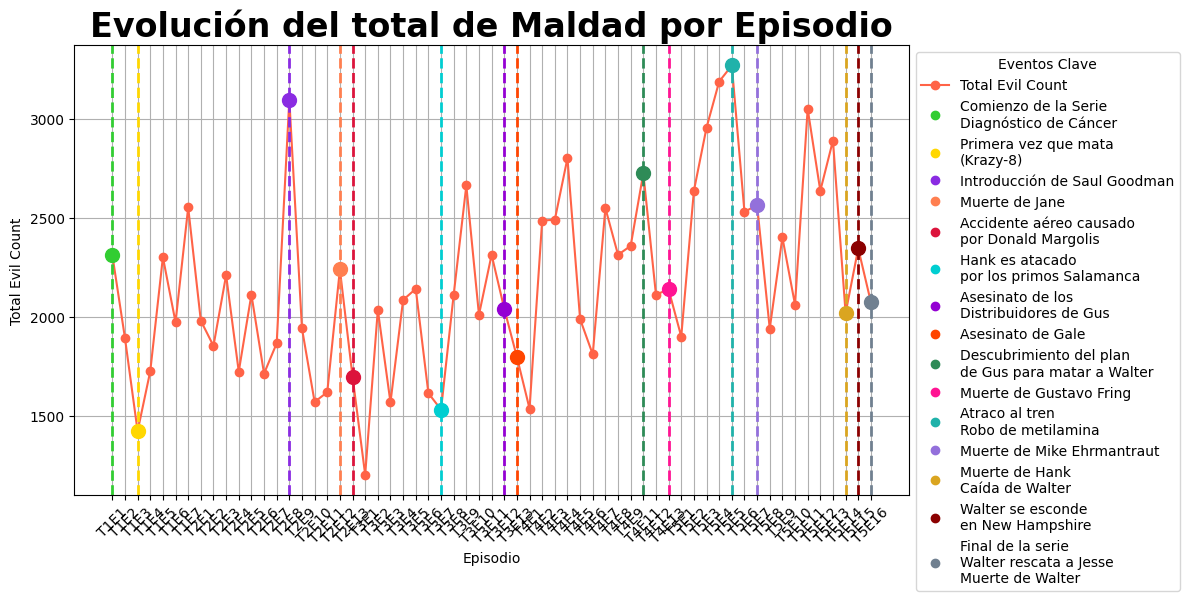

In [88]:
plot_resumen_evil_count(totales_por_episodio, key_events, event_colors)

Se inicia la función para obtener la gráfica del Síndrome de Hubris

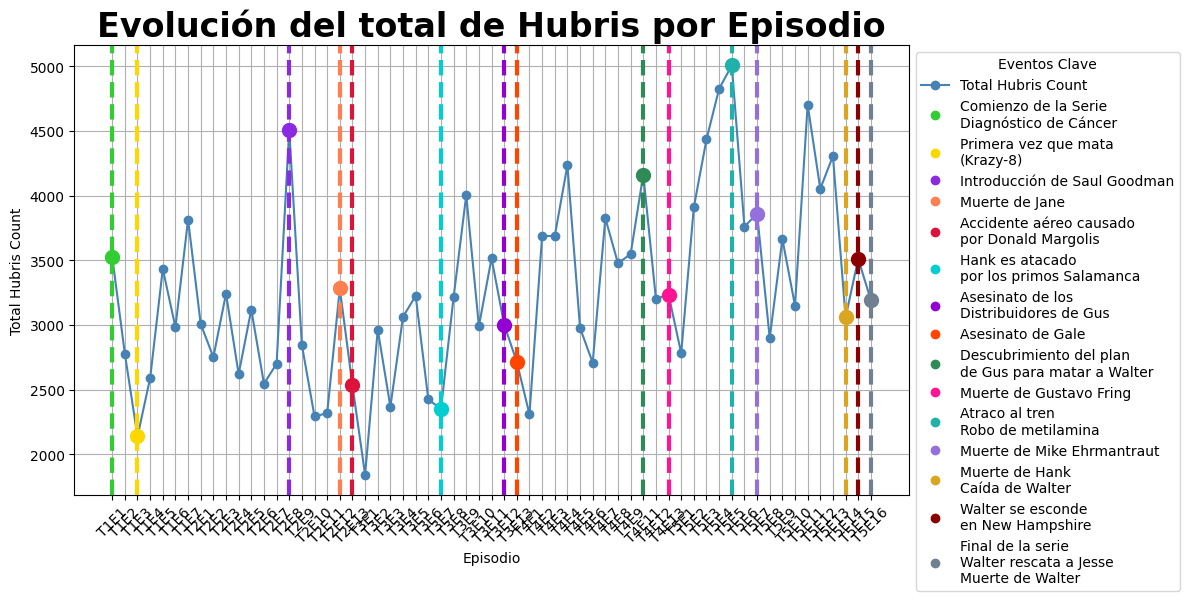

In [89]:
plot_resumen_hubris_count(totales_por_episodio, key_events, event_colors)

#### Función para analizar y generar una gráfica de comparación de la evolución de la Maldad con respecto a la presencia de características del Síndrome de Hubris

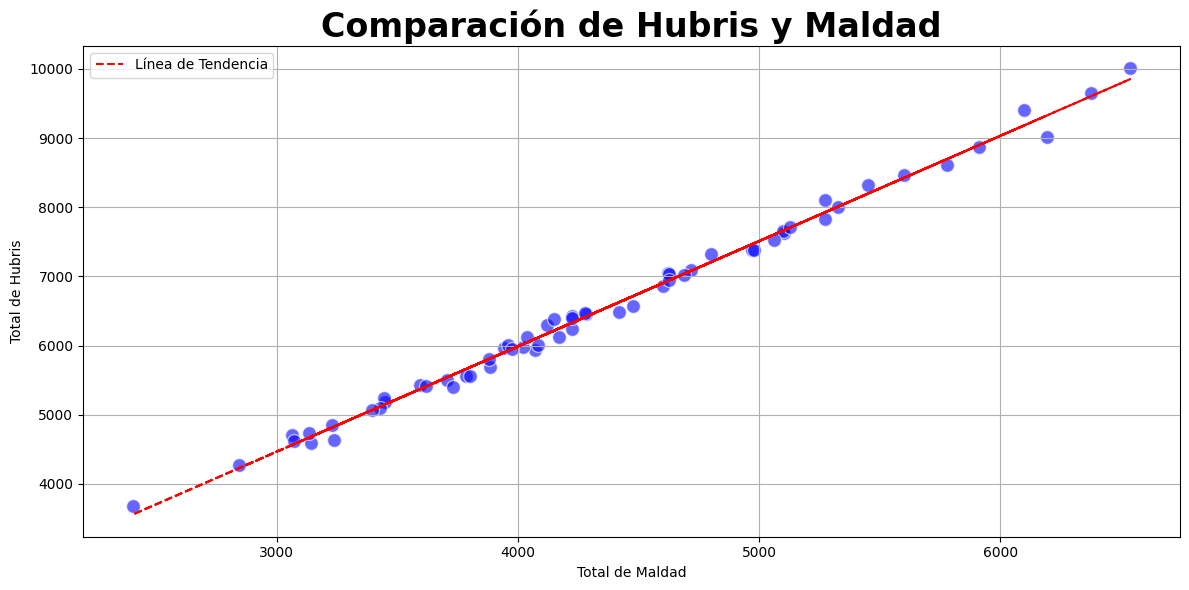

In [90]:
def plot_scatter_hubris_vs_evil(df_contributions):
    """Genera un diagrama de dispersión que compara Hubris y maldad."""
    plt.figure(figsize=(12, 6))

    # Separar las métricas de maldad y Hubris
    evil_columns = [col for col in df_contributions.columns if 'Evil' in col]
    hubris_columns = [col for col in df_contributions.columns if 'Hubris' in col]

    # Calcular los totales de maldad y Hubris
    total_evil = df_contributions[evil_columns].sum(axis=1)
    total_hubris = df_contributions[hubris_columns].sum(axis=1)

    # Crear el diagrama de dispersión
    plt.scatter(total_evil, total_hubris, color='blue', alpha=0.6, edgecolors='w', s=100)

    # Calcular la línea de tendencia
    z = np.polyfit(total_evil, total_hubris, 1)  # Ajuste lineal
    p = np.poly1d(z)
    plt.plot(total_evil, p(total_evil), color='red', linestyle='--', label='Línea de Tendencia')

    # Etiquetas y título
    plt.title('Comparación de Hubris y Maldad', fontsize=24, fontweight='bold')
    plt.xlabel('Total de Maldad')
    plt.ylabel('Total de Hubris')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Uso de la función
file_path = '/content/drive/MyDrive/Capstone Breaking Bad Cristina F./resumen_datos_columnas.xlsx'
data= cargar_excel(file_path)
plot_scatter_hubris_vs_evil(data)

In [91]:
def plot_correlation_heatmap(df):
    """Genera un heatmap de correlación entre niveles de maldad y características de hubris."""
    # Seleccionar columnas relevantes
    correlation_columns = [
        'Evil Count Level 1: Selfish Evil',
        'Evil Count Level 2: Manipulative Evil',
        'Evil Count Level 3: Aggressive Evil',
        'Evil Count Level 4: Dehumanizing Evil',
        'Evil Count Level 5: Sadistic Evil',
        'Hubris Count Arrogance and Pride',
        'Hubris Count Power and Control',
        'Hubris Count Disregard for Rules',
        'Hubris Count Self-Justification',
        'Hubris Count Grandiosity and Transcendence',
        'Hubris Count Excessive Emotions'
    ]

    # Calcular la matriz de correlación
    correlation_matrix = df[correlation_columns].corr()

    # Crear el heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Heatmap de Correlación entre Maldad y Hubris', fontsize=18)
    plt.show()

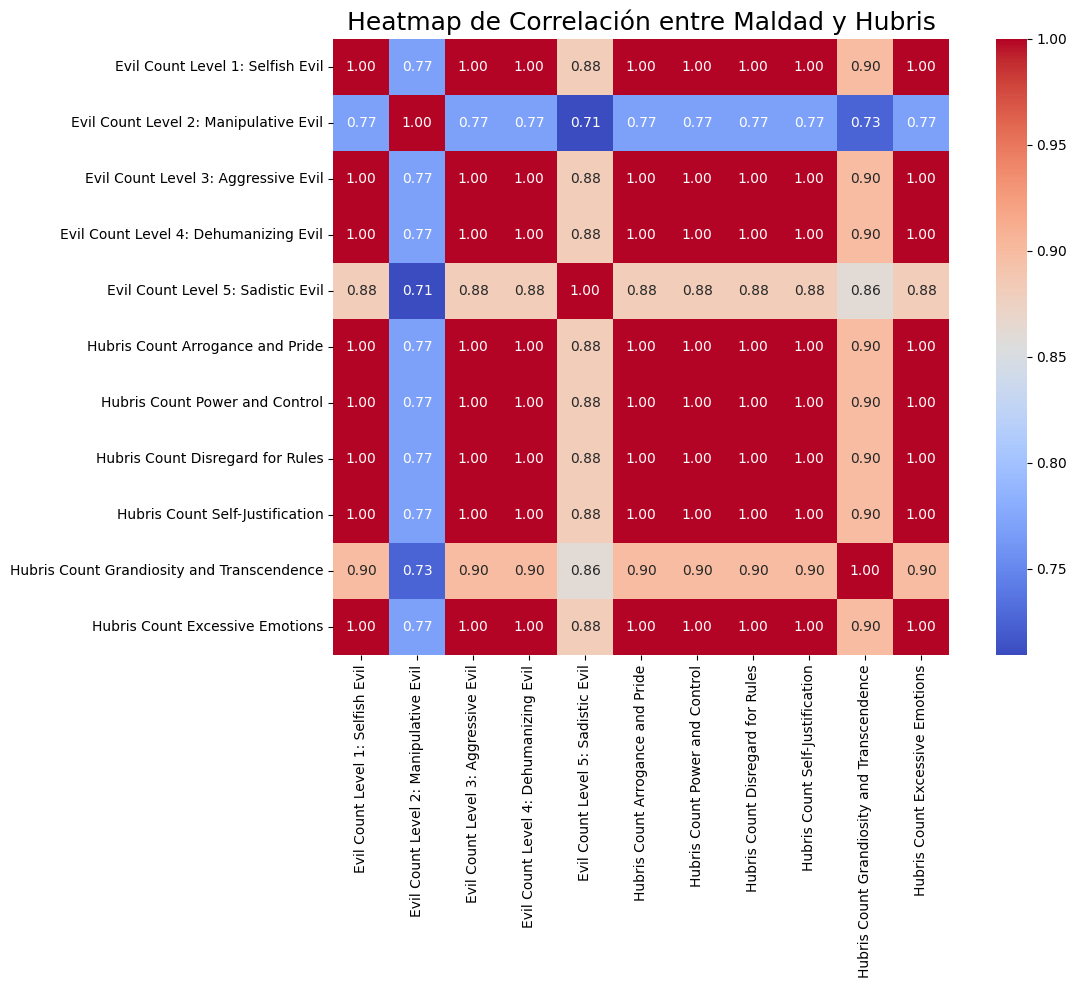

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/Capstone Breaking Bad Cristina F./datos_columnas.xlsx'
df = cargar_excel(file_path)

totales_por_episodio = df.groupby(['Temporada', 'Episodio'])[
       ['Evil Count Level 1: Selfish Evil',
        'Evil Count Level 2: Manipulative Evil',
        'Evil Count Level 3: Aggressive Evil',
        'Evil Count Level 4: Dehumanizing Evil',
        'Evil Count Level 5: Sadistic Evil',
        'Hubris Count Arrogance and Pride',
        'Hubris Count Power and Control',
        'Hubris Count Disregard for Rules',
        'Hubris Count Self-Justification',
        'Hubris Count Grandiosity and Transcendence',
        'Hubris Count Excessive Emotions', 'Total Evil Count', 'Total Hubris Count']].sum().reset_index()
plot_correlation_heatmap(totales_por_episodio)

#### Funciones para mostrar y analizar los resultados comparando diversos personajes.

##### Funciones para mostrar los totales de Maldad y Síndrome de Hubris de varios personajes

Inicialmente se diseña una función que transforme las características de cada categoría a un valor numérico para que el programa pueda analizarlo y generar las gráficas correspondientes.

In [93]:
def caracteristicas_a_numerico(df, metrics_columns):
    for column in metrics_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

Posteriormente se diseña una función que agrupe y calcule el total de Maldad y Síndrome de Hubris por cada personaje

In [94]:
def summarize_data(df, characters):
    filtered_df = df[df['Hablante'].isin(characters)]

    # Verificar el DataFrame filtrado
    print("DataFrame filtrado:")
    print(filtered_df)

    total_counts = filtered_df.groupby('Hablante').agg({
        'Evil Count Level 1: Selfish Evil': 'sum',
        'Evil Count Level 2: Manipulative Evil': 'sum',
        'Evil Count Level 3: Aggressive Evil': 'sum',
        'Evil Count Level 4: Dehumanizing Evil': 'sum',
        'Evil Count Level 5: Sadistic Evil': 'sum',
        'Hubris Count Arrogance and Pride': 'sum',
        'Hubris Count Power and Control': 'sum',
        'Hubris Count Disregard for Rules': 'sum',
        'Hubris Count Self-Justification': 'sum',
        'Hubris Count Grandiosity and Transcendence': 'sum',
        'Hubris Count Excessive Emotions': 'sum'
    }).reset_index()

    # Calcular totales generales de maldad y Hubris
    total_counts['Total Evil'] = total_counts[['Evil Count Level 1: Selfish Evil',
                                                'Evil Count Level 2: Manipulative Evil',
                                                'Evil Count Level 3: Aggressive Evil',
                                                'Evil Count Level 4: Dehumanizing Evil',
                                                'Evil Count Level 5: Sadistic Evil']].sum(axis=1)

    total_counts['Total Hubris'] = total_counts[['Hubris Count Arrogance and Pride',
                                                  'Hubris Count Power and Control',
                                                  'Hubris Count Disregard for Rules',
                                                  'Hubris Count Self-Justification',
                                                  'Hubris Count Grandiosity and Transcendence',
                                                  'Hubris Count Excessive Emotions']].sum(axis=1)

    return total_counts

Se diseña la función para obtener los gráficos de barras correspondientes a la cantidad total de Maldad y Síndrome de Hubris por cada personaje seleccionado.

In [95]:
def plot_totals(total_counts):
    plt.figure(figsize=(12, 6))

    # Gráfico de maldad
    plt.subplot(1, 2, 1)
    plt.bar(total_counts['Hablante'], total_counts['Total Evil'], color='#FF6347')
    plt.title('Total de Maldad por Personaje', fontsize=24, fontweight='bold')
    plt.xlabel('Personaje')
    plt.ylabel('Total de Maldad')
    plt.xticks(rotation=45)

    # Gráfico de Hubris
    plt.subplot(1, 2, 2)
    plt.bar(total_counts['Hablante'], total_counts['Total Hubris'], color='#4682B4')
    plt.title('Total de Hubris por Personaje', fontsize=24, fontweight='bold')
    plt.xlabel('Personaje')
    plt.ylabel('Total de Hubris')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

Se especifican la ruta del archivo y las métricas a tener en cuenta, se ejecutan las funciones para preparar los datos de los personajes deseados y se comprueba si hay datos antes de iniciar la función que ofrece las gráficas.  

DataFrame filtrado:
       Temporada  Episodio Hablante  \
0              1         1   walter   
1              1         1   skyler   
2              1         1   walter   
3              1         1   skyler   
4              1         1   walter   
...          ...       ...      ...   
22095          5        16   walter   
22096          5        16   walter   
22097          5        16   walter   
22099          5        16   walter   
22100          5        16   walter   

                                                   Frase  \
0      my name is walter hartwell white i live at 308...   
1                                         happy birthday   
2                                           look at that   
3      that is veggie bacon believe it or not zero ch...   
4                                              same time   
...                                                  ...   
22095                             like youve got the flu   
22096                 that woul

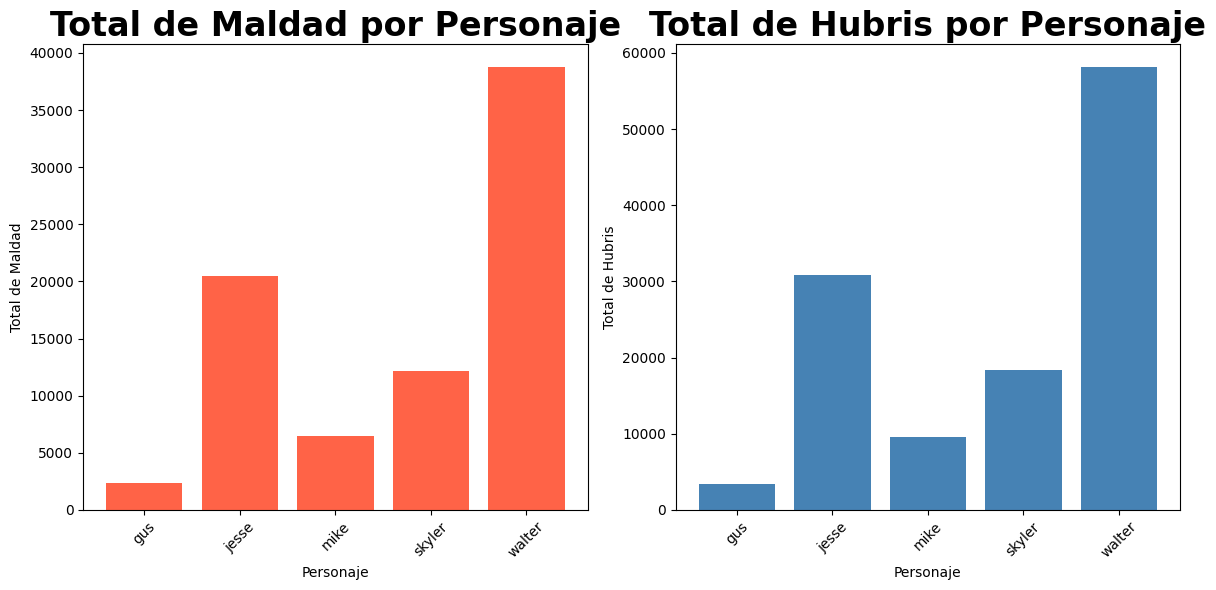

In [96]:
# Especificar la ruta del archivo y las métricas
file_path = '/content/drive/MyDrive/Capstone Breaking Bad Cristina F./datos_columnas.xlsx'
metrics_columns = [
    'Evil Count Level 1: Selfish Evil',
    'Evil Count Level 2: Manipulative Evil',
    'Evil Count Level 3: Aggressive Evil',
    'Evil Count Level 4: Dehumanizing Evil',
    'Evil Count Level 5: Sadistic Evil',
    'Hubris Count Arrogance and Pride',
    'Hubris Count Power and Control',
    'Hubris Count Disregard for Rules',
    'Hubris Count Self-Justification',
    'Hubris Count Grandiosity and Transcendence',
    'Hubris Count Excessive Emotions'
]

# Ejecutar las funciones
characters = ['walter', 'jesse', 'skyler', 'gus', 'mike']
df = cargar_excel(file_path)
df = caracteristicas_a_numerico(df, metrics_columns)
total_counts = summarize_data(df, characters)

# Verificar si hay datos antes de graficar
if total_counts.empty:
    print("No se encontraron datos para los personajes especificados.")
else:
    plot_totals(total_counts)

##### Funciones para mostrar la aportación de varios personajes a los totales de Maldad y Síndrome de Hubris

In [97]:
def analyze_character_contributions(df, characters, metrics_columns):
    """Calcula las contribuciones de los personajes a las cuentas de maldad y Hubris."""
    contributions = {}
    for character in characters:
        character_data = df[df['Hablante'].str.lower() == character.lower()]
        total_contribution = character_data[metrics_columns].sum()
        contributions[character] = total_contribution

    return contributions

In [98]:
characters = ['Walter', 'Jesse', 'Skyler', 'Gus', 'Mike']
metrics_columns = [
    'Evil Count Level 1: Selfish Evil',
    'Evil Count Level 2: Manipulative Evil',
    'Evil Count Level 3: Aggressive Evil',
    'Evil Count Level 4: Dehumanizing Evil',
    'Evil Count Level 5: Sadistic Evil',
    'Hubris Count Arrogance and Pride',
    'Hubris Count Power and Control',
    'Hubris Count Disregard for Rules',
    'Hubris Count Self-Justification',
    'Hubris Count Grandiosity and Transcendence',
    'Hubris Count Excessive Emotions'
]

contributions = analyze_character_contributions(df, characters, metrics_columns)
print(contributions)

{'Walter': Evil Count Level 1: Selfish Evil              10448
Evil Count Level 2: Manipulative Evil          2050
Evil Count Level 3: Aggressive Evil           10448
Evil Count Level 4: Dehumanizing Evil         10448
Evil Count Level 5: Sadistic Evil              5421
Hubris Count Arrogance and Pride              10448
Hubris Count Power and Control                10448
Hubris Count Disregard for Rules              10448
Hubris Count Self-Justification               10448
Hubris Count Grandiosity and Transcendence     5976
Hubris Count Excessive Emotions               10448
dtype: int64, 'Jesse': Evil Count Level 1: Selfish Evil              5494
Evil Count Level 2: Manipulative Evil         1145
Evil Count Level 3: Aggressive Evil           5494
Evil Count Level 4: Dehumanizing Evil         5494
Evil Count Level 5: Sadistic Evil             2892
Hubris Count Arrogance and Pride              5494
Hubris Count Power and Control                5494
Hubris Count Disregard for Rules     

In [99]:
# Guardamos los datos obtenidos de la función analyze_character_contributions en un diccionario para facilitar su trabajo posterior
data = {
    'Walter': {
        'Evil Count Level 1: Selfish Evil': 10448,
        'Evil Count Level 2: Manipulative Evil': 2050,
        'Evil Count Level 3: Aggressive Evil': 10448,
        'Evil Count Level 4: Dehumanizing Evil': 10448,
        'Evil Count Level 5: Sadistic Evil': 5421,
        'Hubris Count Arrogance and Pride': 10448,
        'Hubris Count Power and Control': 10448,
        'Hubris Count Disregard for Rules': 10448,
        'Hubris Count Self-Justification': 10448,
        'Hubris Count Grandiosity and Transcendence': 5976,
        'Hubris Count Excessive Emotions': 10448,
    },
    'Jesse': {
        'Evil Count Level 1: Selfish Evil': 5494,
        'Evil Count Level 2: Manipulative Evil': 1145,
        'Evil Count Level 3: Aggressive Evil': 5494,
        'Evil Count Level 4: Dehumanizing Evil': 5494,
        'Evil Count Level 5: Sadistic Evil': 2892,
        'Hubris Count Arrogance and Pride': 5494,
        'Hubris Count Power and Control': 5494,
        'Hubris Count Disregard for Rules': 5494,
        'Hubris Count Self-Justification': 5494,
        'Hubris Count Grandiosity and Transcendence': 3367,
        'Hubris Count Excessive Emotions': 5494,
    },
    'Skyler': {
        'Evil Count Level 1: Selfish Evil': 3340,
        'Evil Count Level 2: Manipulative Evil': 569,
        'Evil Count Level 3: Aggressive Evil': 3340,
        'Evil Count Level 4: Dehumanizing Evil': 3340,
        'Evil Count Level 5: Sadistic Evil': 1532,
        'Hubris Count Arrogance and Pride': 3340,
        'Hubris Count Power and Control': 3340,
        'Hubris Count Disregard for Rules': 3340,
        'Hubris Count Self-Justification': 3340,
        'Hubris Count Grandiosity and Transcendence': 1723,
        'Hubris Count Excessive Emotions': 3340,
    },
    'Gus': {
        'Evil Count Level 1: Selfish Evil': 628,
        'Evil Count Level 2: Manipulative Evil': 98,
        'Evil Count Level 3: Aggressive Evil': 628,
        'Evil Count Level 4: Dehumanizing Evil': 628,
        'Evil Count Level 5: Sadistic Evil': 352,
        'Hubris Count Arrogance and Pride': 628,
        'Hubris Count Power and Control': 628,
        'Hubris Count Disregard for Rules': 628,
        'Hubris Count Self-Justification': 628,
        'Hubris Count Grandiosity and Transcendence': 324,
        'Hubris Count Excessive Emotions': 628,
    },
    'Mike': {
        'Evil Count Level 1: Selfish Evil': 1725,
        'Evil Count Level 2: Manipulative Evil': 352,
        'Evil Count Level 3: Aggressive Evil': 1725,
        'Evil Count Level 4: Dehumanizing Evil': 1725,
        'Evil Count Level 5: Sadistic Evil': 981,
        'Hubris Count Arrogance and Pride': 1725,
        'Hubris Count Power and Control': 1725,
        'Hubris Count Disregard for Rules': 1725,
        'Hubris Count Self-Justification': 1725,
        'Hubris Count Grandiosity and Transcendence': 939,
        'Hubris Count Excessive Emotions': 1725,
    }
}

In [100]:
def prepare_data_contribution(data):
    """Convierte el diccionario de contribuciones a un DataFrame."""
    df = pd.DataFrame(data).T  # Transponer para tener personajes como filas
    return df

In [101]:
def analyze_sum_character_contributions(df):
    """Suma las contribuciones de maldad y Hubris por personaje."""
    df =  df.sum(axis=1)
    return df

In [102]:
def calculate_percentage_contribution(df):
    """Calcula el porcentaje de contribución de cada tipo de maldad y Hubris."""
    df = df.div(df.sum(axis=1), axis=0) * 100
    return df

In [103]:
def plot_contributions(df, title):
    """Grafica las contribuciones de los personajes."""
    plt.figure(figsize=(12, 6))
    df.plot(kind='bar', stacked=True)
    plt.title(title, fontsize=24, fontweight='bold')
    plt.xlabel('Personajes')
    plt.ylabel('Puntos de Maldad y Hubris')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Métricas')
    plt.tight_layout()
    plt.show()

In [104]:
def summarize_statistics(df):
    """Genera un resumen estadístico de las métricas."""
    df = df.describe()
    return df

In [105]:
def analyze_evil(data):
    """Análisis de contribuciones de maldad."""
    df_contributions = prepare_data_contribution(data)
    evil_columns = [col for col in df_contributions.columns if 'Evil' in col]

    evil_df = df_contributions[evil_columns]

    totales_por_personaje = analyze_sum_character_contributions(evil_df)
    print("Totales por personaje (Evil):\n", totales_por_personaje)

    porcentajes_contribucion = calculate_percentage_contribution(evil_df)
    print("\nPorcentajes de contribución (Evil):\n", porcentajes_contribucion)

    plot_contributions(evil_df, 'Contribución a la Maldad por Personaje')
    resumen_estadistico = summarize_statistics(evil_df)
    print("\nResumen estadístico (Evil):\n", resumen_estadistico)

In [106]:
def analyze_hubris(data):
    """Análisis de contribuciones de Hubris."""
    df_contributions = prepare_data_contribution(data)
    hubris_columns = [col for col in df_contributions.columns if 'Hubris' in col]

    hubris_df = df_contributions[hubris_columns]

    totales_por_personaje = analyze_sum_character_contributions(hubris_df)
    print("Totales por personaje (Hubris):\n", totales_por_personaje)

    porcentajes_contribucion = calculate_percentage_contribution(hubris_df)
    print("\nPorcentajes de contribución (Hubris):\n", porcentajes_contribucion)

    plot_contributions(hubris_df, 'Contribución al Hubris por Personaje')
    resumen_estadistico = summarize_statistics(hubris_df)
    print("\nResumen estadístico (Hubris):\n", resumen_estadistico)

Totales por personaje (Evil):
 Walter    38815
Jesse     20519
Skyler    12121
Gus        2334
Mike       6508
dtype: int64

Porcentajes de contribución (Evil):
         Evil Count Level 1: Selfish Evil  \
Walter                         26.917429   
Jesse                          26.775184   
Skyler                         27.555482   
Gus                            26.906598   
Mike                           26.505839   

        Evil Count Level 2: Manipulative Evil  \
Walter                               5.281463   
Jesse                                5.580194   
Skyler                               4.694332   
Gus                                  4.198800   
Mike                                 5.408728   

        Evil Count Level 3: Aggressive Evil  \
Walter                            26.917429   
Jesse                             26.775184   
Skyler                            27.555482   
Gus                               26.906598   
Mike                              26.505839

<Figure size 1200x600 with 0 Axes>

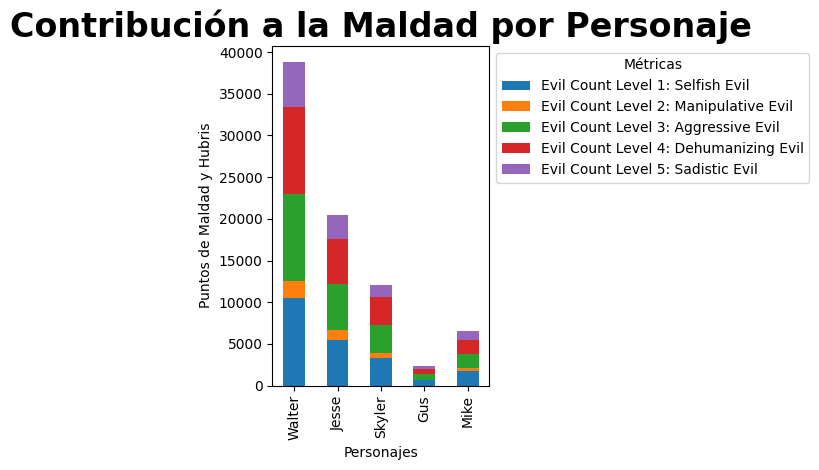


Resumen estadístico (Evil):
        Evil Count Level 1: Selfish Evil  \
count                          5.000000   
mean                        4327.000000   
std                         3881.227383   
min                          628.000000   
25%                         1725.000000   
50%                         3340.000000   
75%                         5494.000000   
max                        10448.000000   

       Evil Count Level 2: Manipulative Evil  \
count                               5.000000   
mean                              842.800000   
std                               777.694477   
min                                98.000000   
25%                               352.000000   
50%                               569.000000   
75%                              1145.000000   
max                              2050.000000   

       Evil Count Level 3: Aggressive Evil  \
count                             5.000000   
mean                           4327.000000   
std        

In [107]:
# Análisis de contribuciones de maldad
analyze_evil(data)

Totales por personaje (Hubris):
 Walter    58216
Jesse     30837
Skyler    18423
Gus        3464
Mike       9564
dtype: int64

Porcentajes de contribución (Hubris):
         Hubris Count Arrogance and Pride  Hubris Count Power and Control  \
Walter                         17.946956                       17.946956   
Jesse                          17.816260                       17.816260   
Skyler                         18.129512                       18.129512   
Gus                            18.129330                       18.129330   
Mike                           18.036386                       18.036386   

        Hubris Count Disregard for Rules  Hubris Count Self-Justification  \
Walter                         17.946956                        17.946956   
Jesse                          17.816260                        17.816260   
Skyler                         18.129512                        18.129512   
Gus                            18.129330                        18.12

<Figure size 1200x600 with 0 Axes>

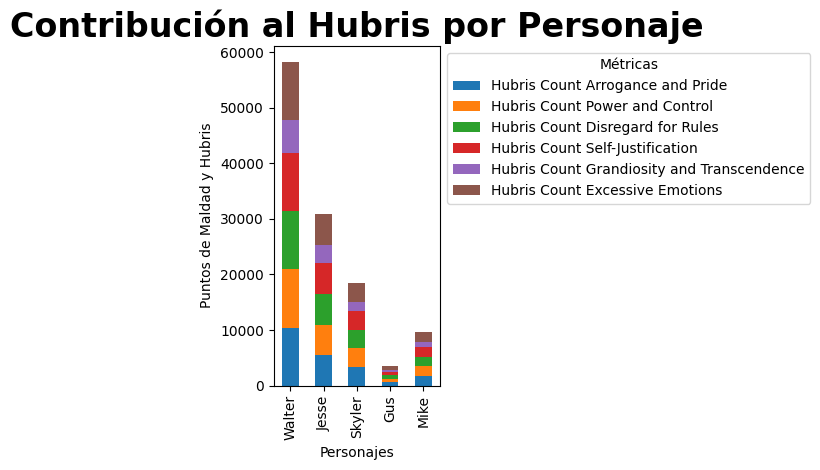


Resumen estadístico (Hubris):
        Hubris Count Arrogance and Pride  Hubris Count Power and Control  \
count                          5.000000                        5.000000   
mean                        4327.000000                     4327.000000   
std                         3881.227383                     3881.227383   
min                          628.000000                      628.000000   
25%                         1725.000000                     1725.000000   
50%                         3340.000000                     3340.000000   
75%                         5494.000000                     5494.000000   
max                        10448.000000                    10448.000000   

       Hubris Count Disregard for Rules  Hubris Count Self-Justification  \
count                          5.000000                         5.000000   
mean                        4327.000000                      4327.000000   
std                         3881.227383                      388

In [108]:
# Análisis de contribuciones de Hubris
analyze_hubris(data)

##### Funciones para comparar las características entre personajes

In [109]:
# Definir la lista de columnas de características individuales para Evil y Hubris
columnas_evil = [
    'Evil Count Level 1: Selfish Evil',
    'Evil Count Level 2: Manipulative Evil',
    'Evil Count Level 3: Aggressive Evil',
    'Evil Count Level 4: Dehumanizing Evil',
    'Evil Count Level 5: Sadistic Evil'
]

columnas_hubris = [
    'Hubris Count Arrogance and Pride',
    'Hubris Count Power and Control',
    'Hubris Count Disregard for Rules',
    'Hubris Count Self-Justification',
    'Hubris Count Grandiosity and Transcendence',
    'Hubris Count Excessive Emotions'
]

# Crear una lista con todas las columnas de características que necesitas en el análisis
columnas_caracteristicas = columnas_evil + columnas_hubris

# Asegúrate de incluir los totales para obtener el valor global también
columnas_totales = ['Total Evil Count', 'Total Hubris Count']

# Filtrar solo las columnas necesarias para agrupar y analizar
columnas_a_incluir = ['Temporada', 'Episodio', 'Hablante'] + columnas_caracteristicas + columnas_totales

#### Funciones para analizar la evolución de un personaje a lo largo de la serie

##### Funciones para analizar y generar una gráfica de lineas de la evolución de Walter

In [110]:
def analizar_personaje(df, character_name, metrics_columns, key_events):
    """Analiza la maldad y el Hubris de un personaje específico a lo largo del tiempo."""
    # Filtrar el DataFrame para el personaje
    character_data = df[df['Hablante'].str.lower() == character_name.lower()]

    # Agrupar los datos por Temporada y Episodio, sumando las métricas seleccionadas
    totales_por_episodio = character_data.groupby(['Temporada', 'Episodio'])[metrics_columns].sum().reset_index()

    return totales_por_episodio

In [111]:
def plot_character_evil_metrics(totales_por_episodio, character_name, key_events, event_colors):
    """Crea gráficos de líneas para los totales de maldad por episodio, anotando eventos clave."""
    plt.figure(figsize=(30, 12))

    # Gráfico de maldad
    plt.subplot(1, 2, 1)
    evil_total = totales_por_episodio[['Evil Count Level 1: Selfish Evil',
                                        'Evil Count Level 2: Manipulative Evil',
                                        'Evil Count Level 3: Aggressive Evil',
                                        'Evil Count Level 4: Dehumanizing Evil',
                                        'Evil Count Level 5: Sadistic Evil']].sum(axis=1)
    plt.plot(totales_por_episodio.index, evil_total, marker='o', color='#FF6347', label='Total de Maldad')
    plt.title(f'Evolución de la Maldad de {character_name}', fontsize=24, fontweight='bold')
    plt.xlabel('Episodio')
    plt.ylabel('Total de Maldad')
    plt.xticks(totales_por_episodio.index, [f'T{row.Temporada}E{row.Episodio}' for _, row in totales_por_episodio.iterrows()], rotation=45)
    plt.grid()

    # Anotar eventos clave para Maldad
    for count, ((temporada, episodio), evento) in enumerate(key_events.items()):
        idx = totales_por_episodio[(totales_por_episodio['Temporada'] == temporada) & (totales_por_episodio['Episodio'] == episodio)]
        if not idx.empty:
            event_idx = idx.index[0]
            plt.plot(event_idx, evil_total[event_idx], 'o', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento

            # Agregar el evento a la leyenda
            plt.plot([], [], 'o', color=event_colors[count % len(event_colors)], label=evento)

            # Marcar con una línea vertical
            plt.axvline(x=event_idx, color=event_colors[count % len(event_colors)], linestyle='--', linewidth=3)

    plt.legend(title='Eventos Clave', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()
    plt.show()

In [112]:
def plot_character_hubris_metrics(totales_por_episodio, character_name, key_events, event_colors):
    """Crea gráficos de líneas para los totales de Hubris por episodio, anotando eventos clave."""
    plt.figure(figsize=(30, 12))

    # Gráfico de Hubris
    plt.subplot(1, 2, 2)
    hubris_total = totales_por_episodio[['Hubris Count Arrogance and Pride',
                                           'Hubris Count Power and Control',
                                           'Hubris Count Disregard for Rules',
                                           'Hubris Count Self-Justification',
                                           'Hubris Count Grandiosity and Transcendence',
                                           'Hubris Count Excessive Emotions']].sum(axis=1)

    plt.plot(totales_por_episodio.index, hubris_total, marker='o', color='#4682B4', label='Total Hubris')
    plt.title(f'Evolución del Hubris de {character_name}', fontsize=24, fontweight='bold')
    plt.xlabel('Episodio')
    plt.ylabel('Total de Hubris')
    plt.xticks(totales_por_episodio.index, [f'T{row.Temporada}E{row.Episodio}' for _, row in totales_por_episodio.iterrows()], rotation=45)
    plt.grid()

    # Anotar eventos clave para Hubris
    for count, ((temporada, episodio), evento) in enumerate(key_events.items()):
        idx = totales_por_episodio[(totales_por_episodio['Temporada'] == temporada) & (totales_por_episodio['Episodio'] == episodio)]
        if not idx.empty:
            event_idx = idx.index[0]
            plt.plot(event_idx, hubris_total[event_idx], 'o', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento

            # Agregar el evento a la leyenda
            plt.plot([], [], 'o', color=event_colors[count % len(event_colors)], label=evento)

            # Marcar con una línea vertical
            plt.axvline(x=event_idx, color=event_colors[count % len(event_colors)], linestyle='--', linewidth=3)

    plt.legend(title='Eventos Clave', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()
    plt.show()

In [113]:
def plot_character_metrics_combined(totales_por_episodio, character_name, key_events, event_colors):
    """Crea un gráfico combinado para los totales de maldad y hubris por episodio, anotando eventos clave."""
    plt.figure(figsize=(30, 12))

    # Gráfico de maldad
    evil_total = totales_por_episodio[['Evil Count Level 1: Selfish Evil',
                                        'Evil Count Level 2: Manipulative Evil',
                                        'Evil Count Level 3: Aggressive Evil',
                                        'Evil Count Level 4: Dehumanizing Evil',
                                        'Evil Count Level 5: Sadistic Evil']].sum(axis=1)

    plt.plot(totales_por_episodio.index, evil_total, marker='o', color='#FF6347', label='Total de Maldad')

    # Gráfico de Hubris
    hubris_total = totales_por_episodio[['Hubris Count Arrogance and Pride',
                                           'Hubris Count Power and Control',
                                           'Hubris Count Disregard for Rules',
                                           'Hubris Count Self-Justification',
                                           'Hubris Count Grandiosity and Transcendence',
                                           'Hubris Count Excessive Emotions']].sum(axis=1)

    plt.plot(totales_por_episodio.index, hubris_total, marker='o', color='#4682B4', label='Total de Hubris')

    # Configuración de títulos y etiquetas
    plt.title(f'Evolución de Maldad y Hubris de {character_name}', fontsize=24, fontweight='bold')
    plt.xlabel('Episodio')
    plt.ylabel('Total')
    plt.xticks(totales_por_episodio.index, [f'T{row.Temporada}E{row.Episodio}' for _, row in totales_por_episodio.iterrows()], rotation=45)
    plt.grid()

    # Anotar eventos clave
    for count, ((temporada, episodio), evento) in enumerate(key_events.items()):
        idx = totales_por_episodio[(totales_por_episodio['Temporada'] == temporada) & (totales_por_episodio['Episodio'] == episodio)]
        if not idx.empty:
            event_idx = idx.index[0]
            plt.axvline(x=event_idx, color=event_colors[count % len(event_colors)], linestyle='--', linewidth=3)
            plt.plot(event_idx, evil_total[event_idx], 'o', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento
            plt.plot(event_idx, hubris_total[event_idx], 'o', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento

            # Agregar el evento a la leyenda
            plt.plot([], [], 'o', color=event_colors[count % len(event_colors)], label=evento)

    plt.legend(title='Eventos Clave', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()
    plt.show()

In [114]:
file_path = '/content/drive/MyDrive/Capstone Breaking Bad Cristina F./datos_columnas.xlsx'
df = cargar_excel(file_path)

In [115]:
character_name = 'walter'
totales_por_episodio = analizar_personaje(df, character_name, metrics_columns, key_events)

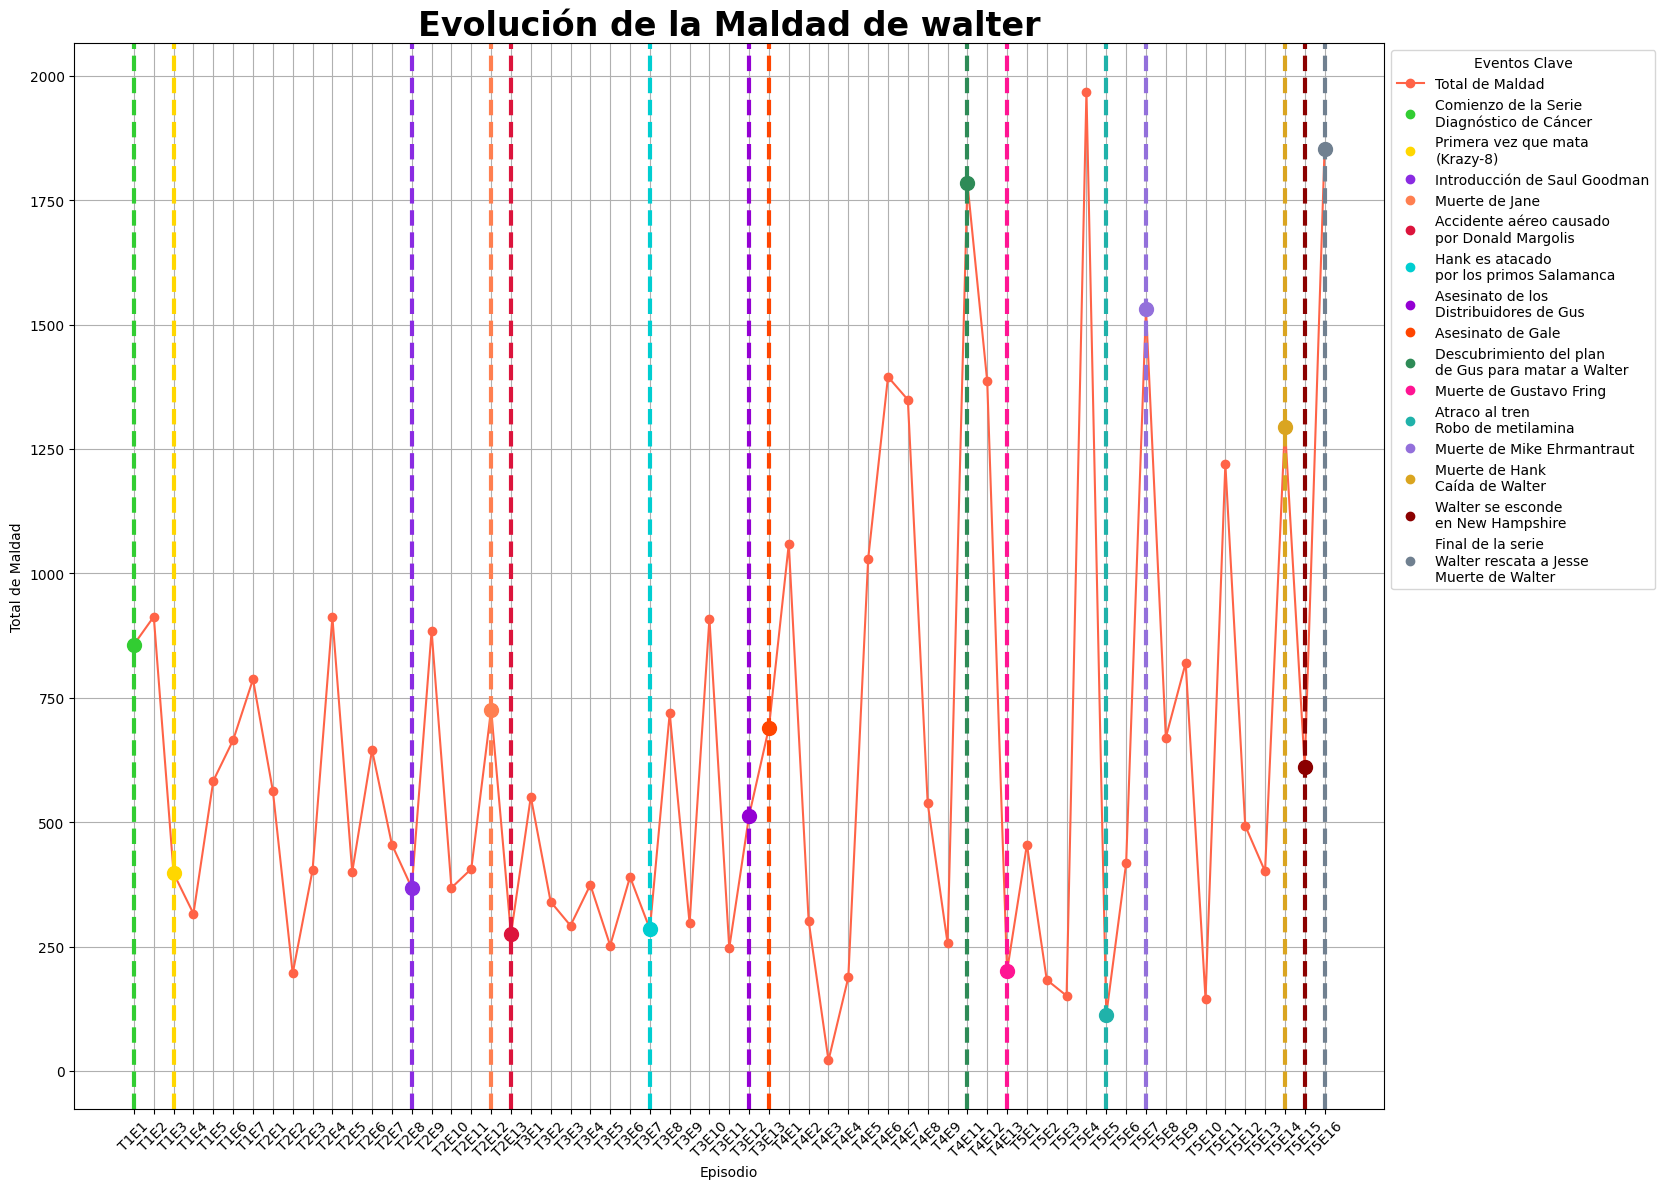

In [116]:
plot_character_evil_metrics(totales_por_episodio, character_name, key_events, event_colors)

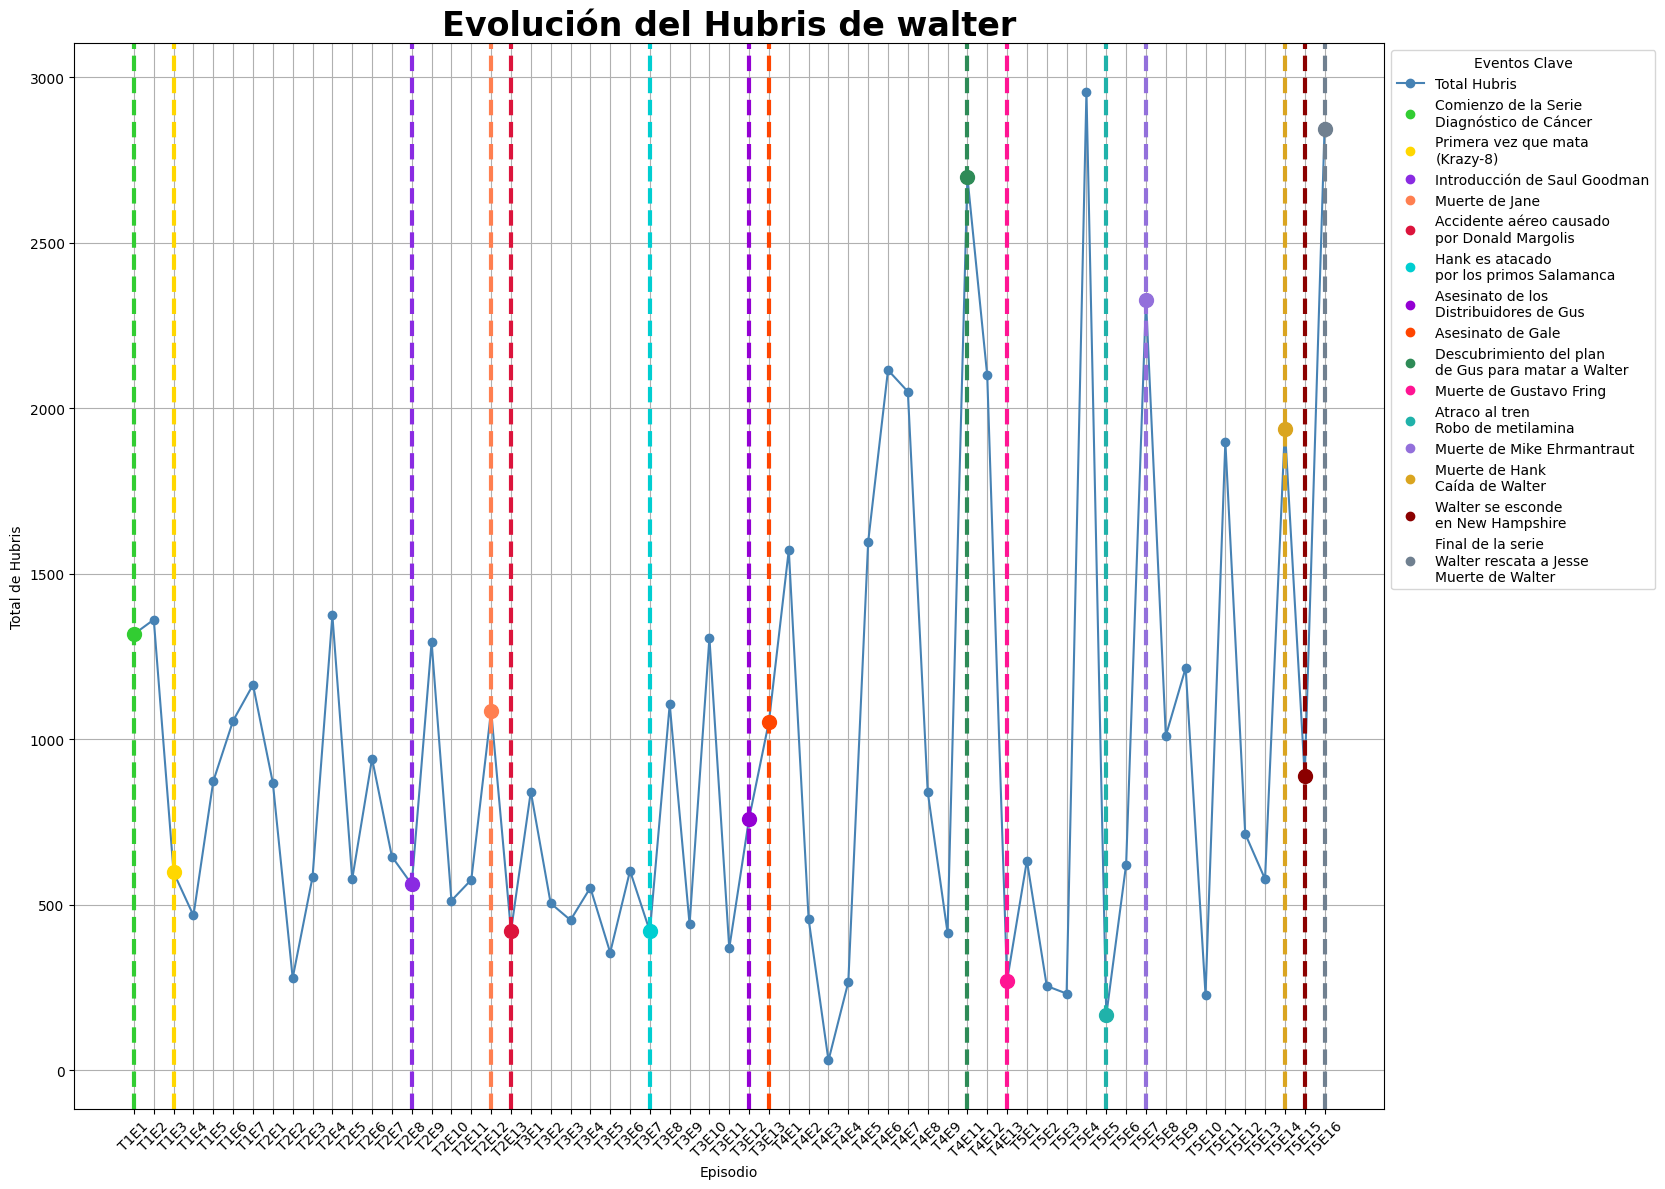

In [117]:
plot_character_hubris_metrics(totales_por_episodio, character_name, key_events, event_colors)

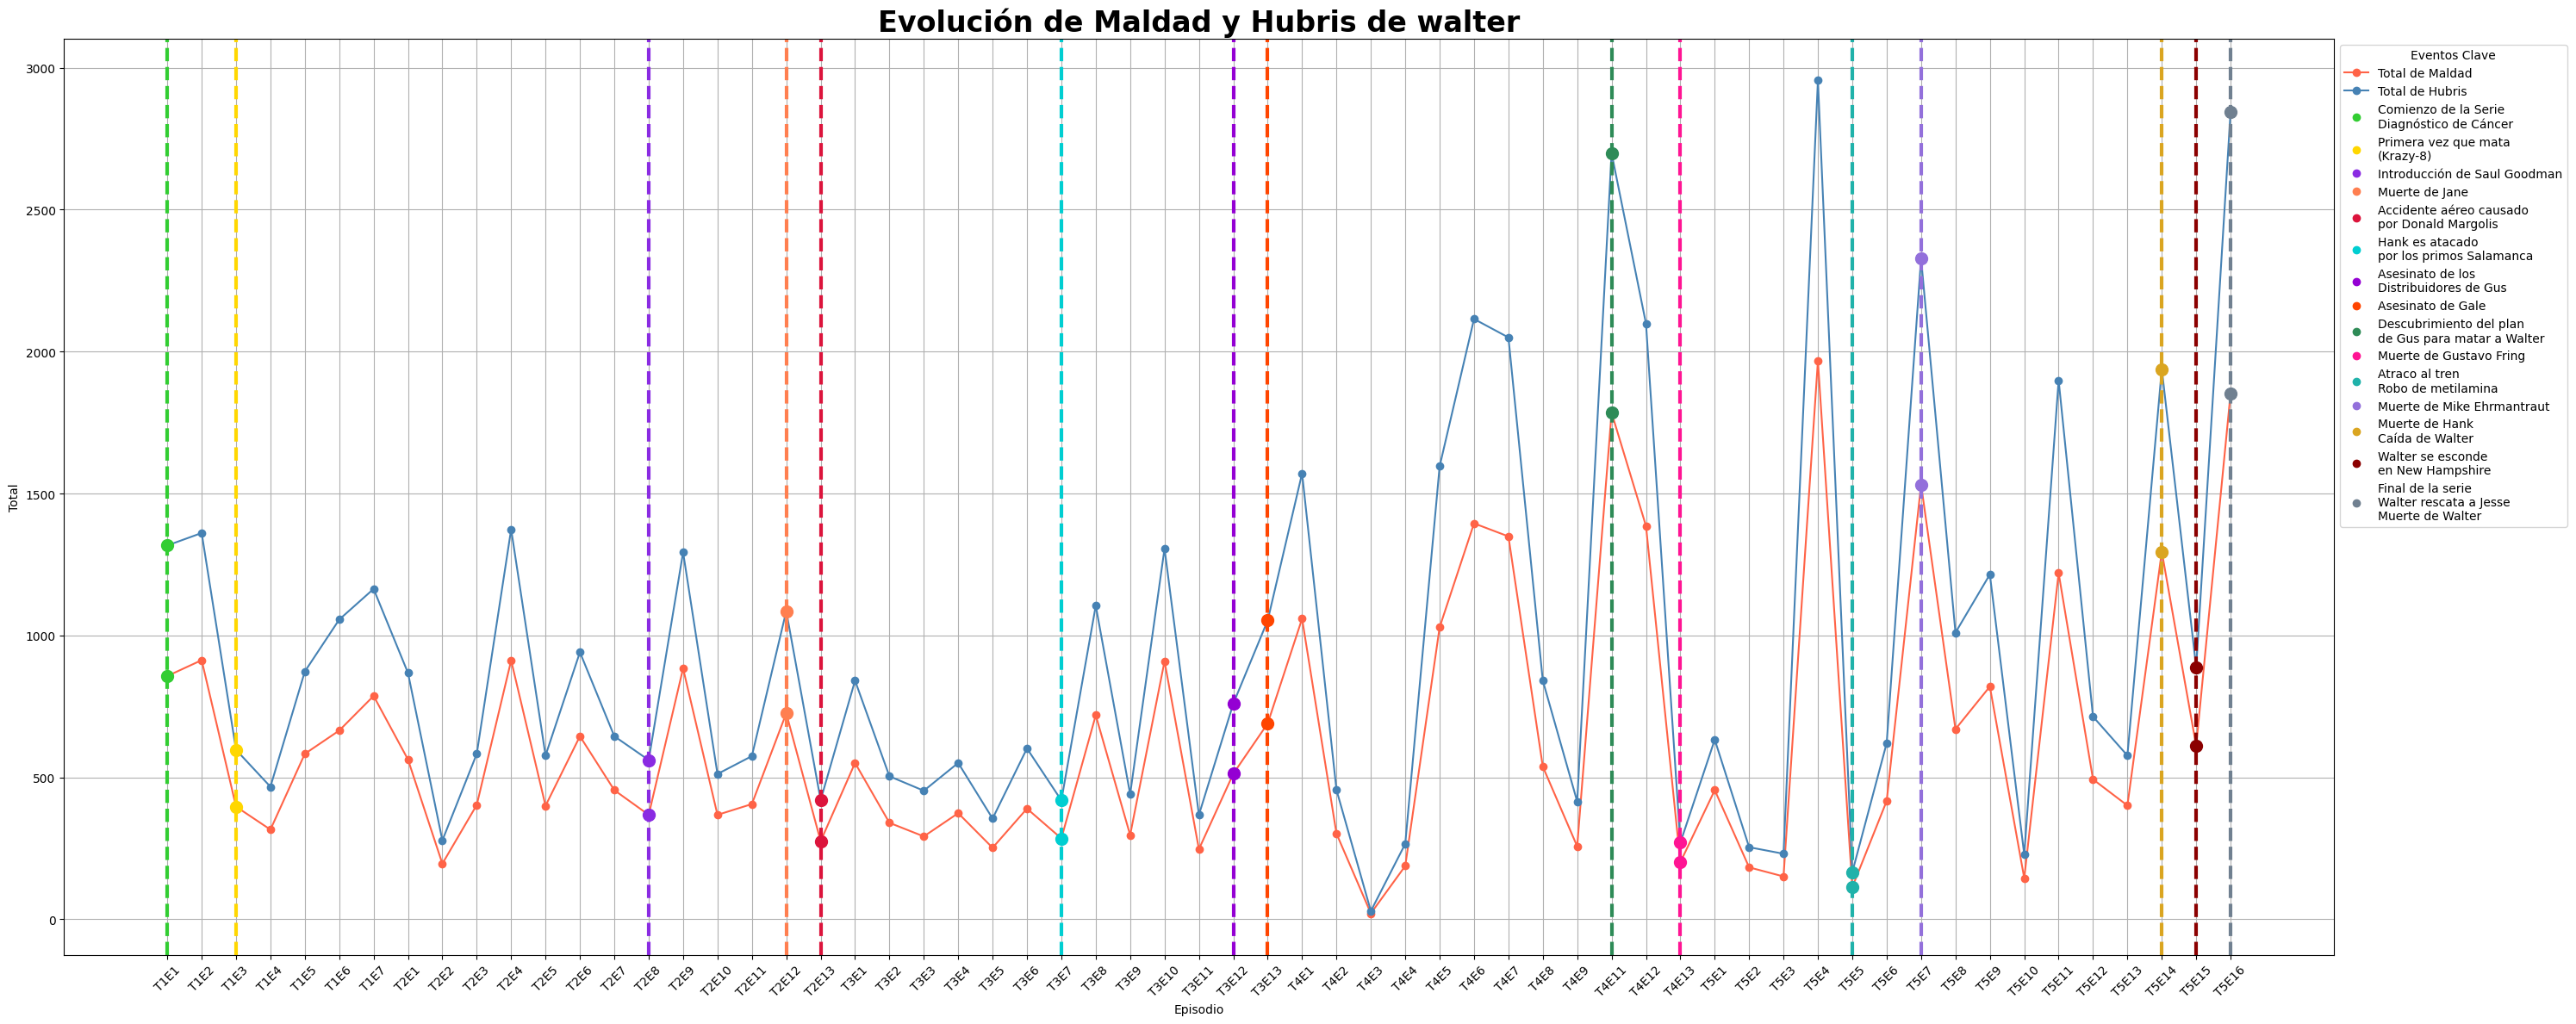

In [118]:
plot_character_metrics_combined(totales_por_episodio, character_name, key_events, event_colors)

##### Funciones para analizar y generar una gráfica de dispersión con la línea de tendencia de la evolución de Walter

In [119]:
def plot_tendencia_hubris(totales_por_episodio, character_name, key_events, event_colors):
    """Crea gráficos de líneas para los totales de Hubris por episodio, anotando eventos clave."""
    plt.figure(figsize=(30, 12))

    # Gráfico de Hubris
    plt.subplot(1, 2, 2)
    hubris_total = totales_por_episodio[['Hubris Count Arrogance and Pride',
                                           'Hubris Count Power and Control',
                                           'Hubris Count Disregard for Rules',
                                           'Hubris Count Self-Justification',
                                           'Hubris Count Grandiosity and Transcendence',
                                           'Hubris Count Excessive Emotions']].sum(axis=1)

    plt.scatter(totales_por_episodio.index, hubris_total, marker='o', color='#4682B4', label='Total Hubris')

    # Calcular la línea de tendencia
    z = np.polyfit(totales_por_episodio.index, hubris_total, 1)  # Ajuste lineal
    p = np.poly1d(z)

    # Graficar la línea de tendencia
    plt.plot(totales_por_episodio.index, p(totales_por_episodio.index), color='red', linestyle='--', label='Línea de Tendencia')


    plt.title(f'Evolución del Hubris de {character_name}', fontsize=24, fontweight='bold')
    plt.xlabel('Episodio')
    plt.ylabel('Total de Hubris')
    plt.xticks(totales_por_episodio.index, [f'T{row.Temporada}E{row.Episodio}' for _, row in totales_por_episodio.iterrows()], rotation=45)
    plt.grid()

    # Anotar eventos clave para Hubris
    for count, ((temporada, episodio), evento) in enumerate(key_events.items()):
        idx = totales_por_episodio[(totales_por_episodio['Temporada'] == temporada) & (totales_por_episodio['Episodio'] == episodio)]
        if not idx.empty:
            event_idx = idx.index[0]
            plt.plot(event_idx, hubris_total[event_idx], 'o', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento

            # Agregar el evento a la leyenda
            plt.plot([], [], 'o', color=event_colors[count % len(event_colors)], label=evento)

            # Marcar con una línea vertical
            plt.axvline(x=event_idx, color=event_colors[count % len(event_colors)], linestyle='--', linewidth=3)

    plt.legend(title='Eventos Clave', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()
    plt.show()

In [120]:
def plot_tendencia_evil(totales_por_episodio, character_name, key_events, event_colors):
    """Crea gráficos de puntos para los totales de Maldad por episodio, anotando eventos clave."""
    plt.figure(figsize=(30, 12))

    # Gráfico de maldad
    plt.subplot(1, 2, 1)
    evil_total = totales_por_episodio[['Evil Count Level 1: Selfish Evil',
                                        'Evil Count Level 2: Manipulative Evil',
                                        'Evil Count Level 3: Aggressive Evil',
                                        'Evil Count Level 4: Dehumanizing Evil',
                                        'Evil Count Level 5: Sadistic Evil']].sum(axis=1)
    plt.scatter(totales_por_episodio.index, evil_total, marker='o', color='#FF6347', label='Total Maldad')

    # Calcular la línea de tendencia
    z = np.polyfit(totales_por_episodio.index, evil_total, 1)  # Ajuste lineal
    p = np.poly1d(z)

    # Graficar la línea de tendencia
    plt.plot(totales_por_episodio.index, p(totales_por_episodio.index), color='red', linestyle='--', label='Línea de Tendencia')


    plt.title(f'Evolución de la Maldad de {character_name}', fontsize=24, fontweight='bold')
    plt.xlabel('Episodio')
    plt.ylabel('Total de Maldad')
    plt.xticks(totales_por_episodio.index, [f'T{row.Temporada}E{row.Episodio}' for _, row in totales_por_episodio.iterrows()], rotation=45)
    plt.grid()

    # Anotar eventos clave para Maldad
    for count, ((temporada, episodio), evento) in enumerate(key_events.items()):
        idx = totales_por_episodio[(totales_por_episodio['Temporada'] == temporada) & (totales_por_episodio['Episodio'] == episodio)]
        if not idx.empty:
            event_idx = idx.index[0]
            plt.plot(event_idx, evil_total[event_idx], 'o', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento

            # Agregar el evento a la leyenda
            plt.plot([], [], 'o', color=event_colors[count % len(event_colors)], label=evento)

            # Marcar con una línea vertical
            plt.axvline(x=event_idx, color=event_colors[count % len(event_colors)], linestyle='--', linewidth=3)

    plt.legend(title='Eventos Clave', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()
    plt.show()

In [121]:
def plot_tendencia_combined(totales_por_episodio, character_name, key_events, event_colors):
    """Crea un gráfico combinado de scatterplot y líneas de tendencia para Hubris y Maldad, anotando eventos clave."""
    plt.figure(figsize=(30, 12))

    # Calcular los totales de Hubris y Maldad
    hubris_total = totales_por_episodio[['Hubris Count Arrogance and Pride',
                                         'Hubris Count Power and Control',
                                         'Hubris Count Disregard for Rules',
                                         'Hubris Count Self-Justification',
                                         'Hubris Count Grandiosity and Transcendence',
                                         'Hubris Count Excessive Emotions']].sum(axis=1)

    evil_total = totales_por_episodio[['Evil Count Level 1: Selfish Evil',
                                       'Evil Count Level 2: Manipulative Evil',
                                       'Evil Count Level 3: Aggressive Evil',
                                       'Evil Count Level 4: Dehumanizing Evil',
                                       'Evil Count Level 5: Sadistic Evil']].sum(axis=1)

    # Gráfico de puntos para Hubris y Maldad
    plt.scatter(totales_por_episodio.index, hubris_total, marker='o', color='#4682B4', label='Total Hubris')
    plt.scatter(totales_por_episodio.index, evil_total, marker='o', color='#FF6347', label='Total Maldad')

    # Calcular y graficar la línea de tendencia para Hubris
    z_hubris = np.polyfit(totales_por_episodio.index, hubris_total, 1)
    p_hubris = np.poly1d(z_hubris)
    plt.plot(totales_por_episodio.index, p_hubris(totales_por_episodio.index), color='#1E90FF', linestyle='--', label='Línea de Tendencia Hubris')

    # Calcular y graficar la línea de tendencia para Maldad
    z_evil = np.polyfit(totales_por_episodio.index, evil_total, 1)
    p_evil = np.poly1d(z_evil)
    plt.plot(totales_por_episodio.index, p_evil(totales_por_episodio.index), color='#FF4500', linestyle='--', label='Línea de Tendencia Maldad')

    plt.title(f'Evolución de Hubris y Maldad de {character_name}', fontsize=24, fontweight='bold')
    plt.xlabel('Episodio')
    plt.ylabel('Total')
    plt.xticks(totales_por_episodio.index, [f'T{row.Temporada}E{row.Episodio}' for _, row in totales_por_episodio.iterrows()], rotation=45)
    plt.grid()

    # Anotar eventos clave para Hubris y Maldad
    for count, ((temporada, episodio), evento) in enumerate(key_events.items()):
        idx = totales_por_episodio[(totales_por_episodio['Temporada'] == temporada) & (totales_por_episodio['Episodio'] == episodio)]
        if not idx.empty:
            event_idx = idx.index[0]

            # Marcar el evento en el gráfico
            plt.plot(event_idx, hubris_total[event_idx], 'o', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento para Hubris
            plt.plot(event_idx, evil_total[event_idx], 'x', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento para Maldad

            # Agregar el evento a la leyenda
            plt.plot([], [], 'o', color=event_colors[count % len(event_colors)], label=f'{evento} (Hubris)')
            plt.plot([], [], 'x', color=event_colors[count % len(event_colors)], label=f'{evento} (Maldad)')

            # Marcar con una línea vertical
            plt.axvline(x=event_idx, color=event_colors[count % len(event_colors)], linestyle='--', linewidth=2)

    plt.legend(title='Eventos Clave', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()
    plt.show()

In [122]:
def plot_evolucion_niveles_maldad(totales_por_episodio, character_name, key_events, event_colors):
    """Crea gráficos de puntos para los diferentes niveles de Maldad por episodio y personaje, anotando eventos clave."""
    plt.figure(figsize=(30, 12))

    # Definir los nombres de las columnas de los diferentes niveles de maldad
    categorias_maldad = [
        'Evil Count Level 1: Selfish Evil',
        'Evil Count Level 2: Manipulative Evil',
        'Evil Count Level 3: Aggressive Evil',
        'Evil Count Level 4: Dehumanizing Evil',
        'Evil Count Level 5: Sadistic Evil'
    ]

    # Graficar cada nivel de maldad por separado
    for nivel in categorias_maldad:
        plt.scatter(totales_por_episodio.index, totales_por_episodio[nivel], label=nivel, s=100, alpha=0.6)

        # Calcular la línea de tendencia para cada nivel
        z = np.polyfit(totales_por_episodio.index, totales_por_episodio[nivel], 1)
        p = np.poly1d(z)

        # Graficar la línea de tendencia
        plt.plot(totales_por_episodio.index, p(totales_por_episodio.index), linestyle='--', label=f'Tendencia {nivel}')

    plt.title(f'Evolución de los Niveles de Maldad de {character_name}', fontsize=24, fontweight='bold')
    plt.xlabel('Episodio')
    plt.ylabel('Puntos de Maldad por Nivel')
    plt.xticks(totales_por_episodio.index, [f'T{row.Temporada}E{row.Episodio}' for _, row in totales_por_episodio.iterrows()], rotation=45)
    plt.grid()

    # Anotar eventos clave en el gráfico
    for count, ((temporada, episodio), evento) in enumerate(key_events.items()):
        idx = totales_por_episodio[(totales_por_episodio['Temporada'] == temporada) & (totales_por_episodio['Episodio'] == episodio)]
        if not idx.empty:
            event_idx = idx.index[0]
            plt.plot(event_idx, totales_por_episodio[nivel].max(), 'o', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento en la altura máxima de la categoría
            # Agregar el evento a la leyenda
            plt.plot([], [], 'o', color=event_colors[count % len(event_colors)], label=evento)
            # Marcar con una línea vertical
            plt.axvline(x=event_idx, color=event_colors[count % len(event_colors)], linestyle='--', linewidth=3)

    plt.legend(title='Niveles de Maldad y Eventos Clave', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()
    plt.show()

In [123]:
def plot_evolucion_niveles_hubris(totales_por_episodio, character_name, key_events, event_colors):
    """Crea gráficos de puntos para los diferentes niveles de Hubris por episodio y personaje, anotando eventos clave."""
    plt.figure(figsize=(30, 12))

    # Definir los nombres de las columnas de los diferentes niveles de Hubris
    categorias_hubris = [
        'Hubris Count Arrogance and Pride',
        'Hubris Count Power and Control',
        'Hubris Count Disregard for Rules',
        'Hubris Count Self-Justification',
        'Hubris Count Grandiosity and Transcendence',
        'Hubris Count Excessive Emotions'
    ]

    # Graficar cada nivel de Hubris por separado
    for nivel in categorias_hubris:
        plt.scatter(totales_por_episodio.index, totales_por_episodio[nivel], label=nivel, s=100, alpha=0.6)

        # Calcular la línea de tendencia para cada nivel
        z = np.polyfit(totales_por_episodio.index, totales_por_episodio[nivel], 1)
        p = np.poly1d(z)

        # Graficar la línea de tendencia
        plt.plot(totales_por_episodio.index, p(totales_por_episodio.index), linestyle='--', label=f'Tendencia {nivel}')

    plt.title(f'Evolución de los Niveles de Hubris de {character_name}', fontsize=24, fontweight='bold')
    plt.xlabel('Episodio')
    plt.ylabel('Puntos de Hubris por Nivel')
    plt.xticks(totales_por_episodio.index, [f'T{row.Temporada}E{row.Episodio}' for _, row in totales_por_episodio.iterrows()], rotation=45)
    plt.grid()

    # Anotar eventos clave en el gráfico
    for count, ((temporada, episodio), evento) in enumerate(key_events.items()):
        idx = totales_por_episodio[(totales_por_episodio['Temporada'] == temporada) & (totales_por_episodio['Episodio'] == episodio)]
        if not idx.empty:
            event_idx = idx.index[0]
            plt.plot(event_idx, totales_por_episodio[nivel].max(), 'o', color=event_colors[count % len(event_colors)], markersize=10)  # Marcar el evento en la altura máxima de la categoría
            # Agregar el evento a la leyenda
            plt.plot([], [], 'o', color=event_colors[count % len(event_colors)], label=evento)
            # Marcar con una línea vertical
            plt.axvline(x=event_idx, color=event_colors[count % len(event_colors)], linestyle='--', linewidth=3)

    plt.legend(title='Niveles de Hubris y Eventos Clave', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tight_layout()
    plt.show()

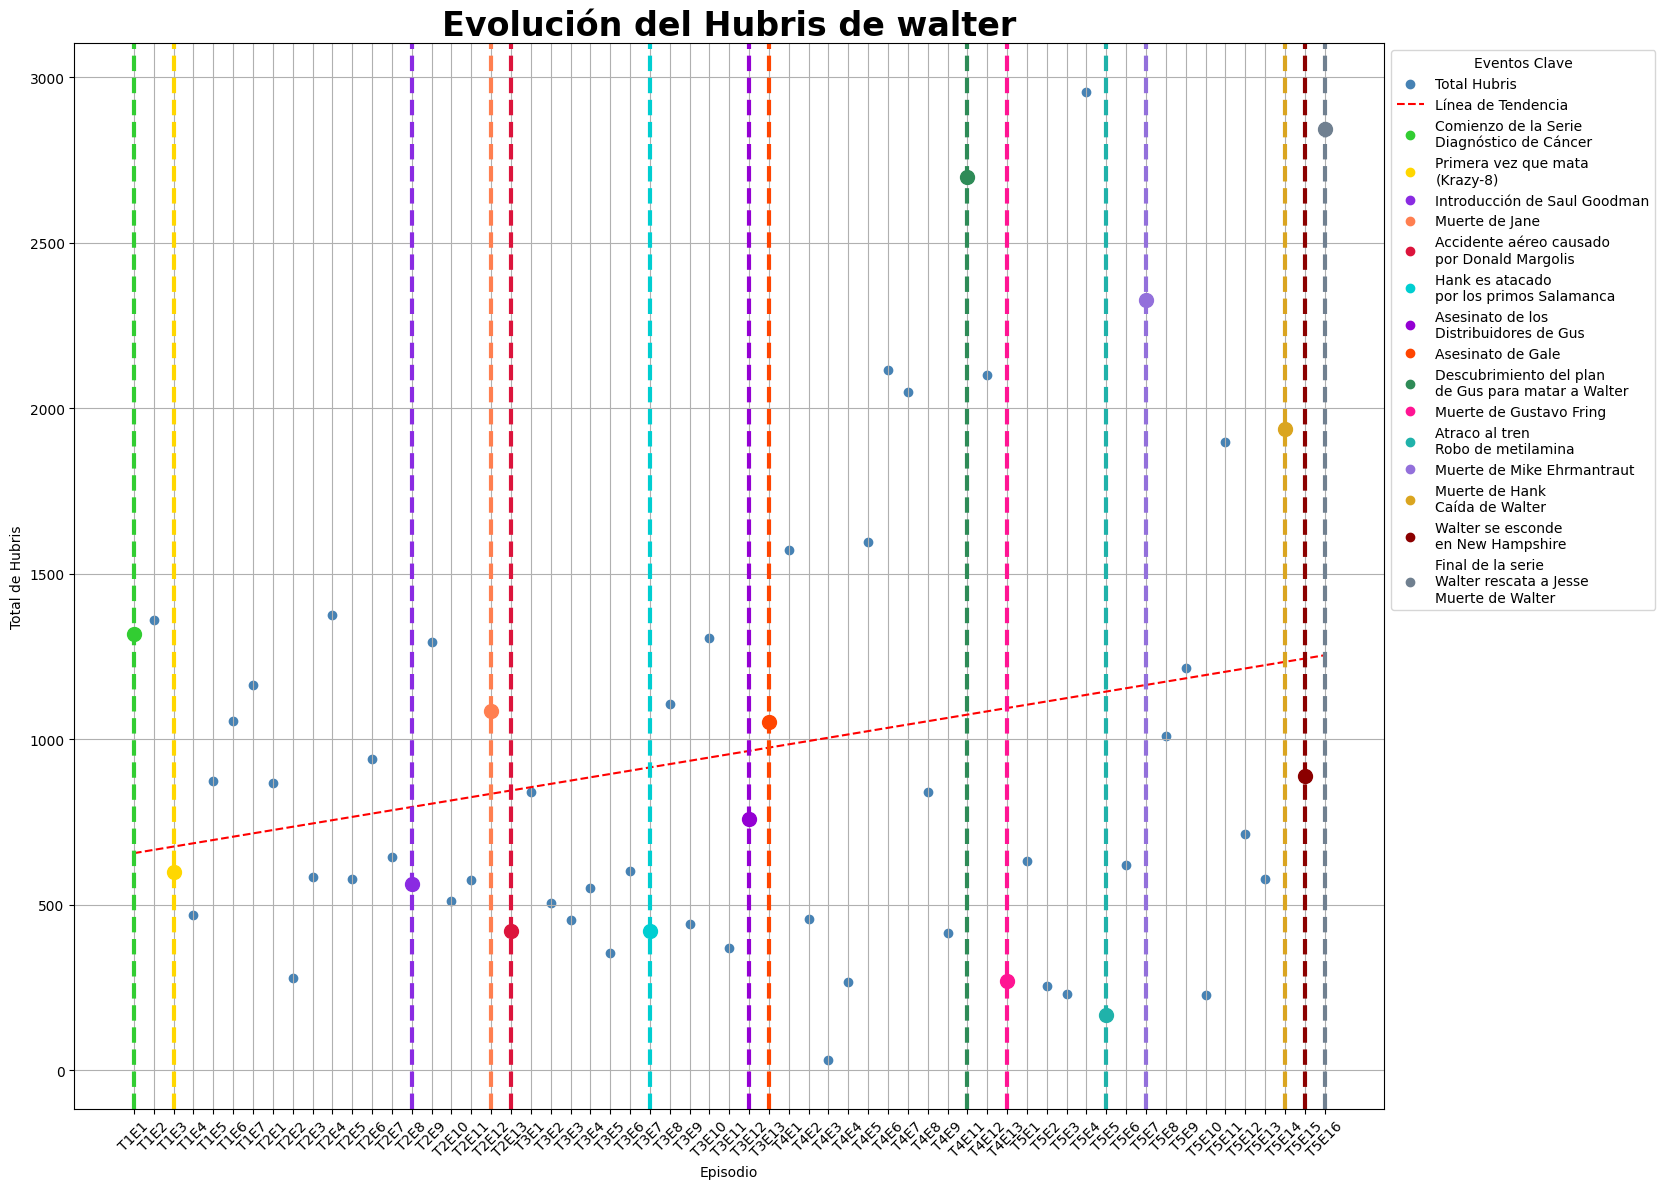

In [124]:
character_name = 'walter'
totales_por_episodio = analizar_personaje(df, character_name, metrics_columns, key_events)
plot_tendencia_hubris(totales_por_episodio, character_name, key_events, event_colors)

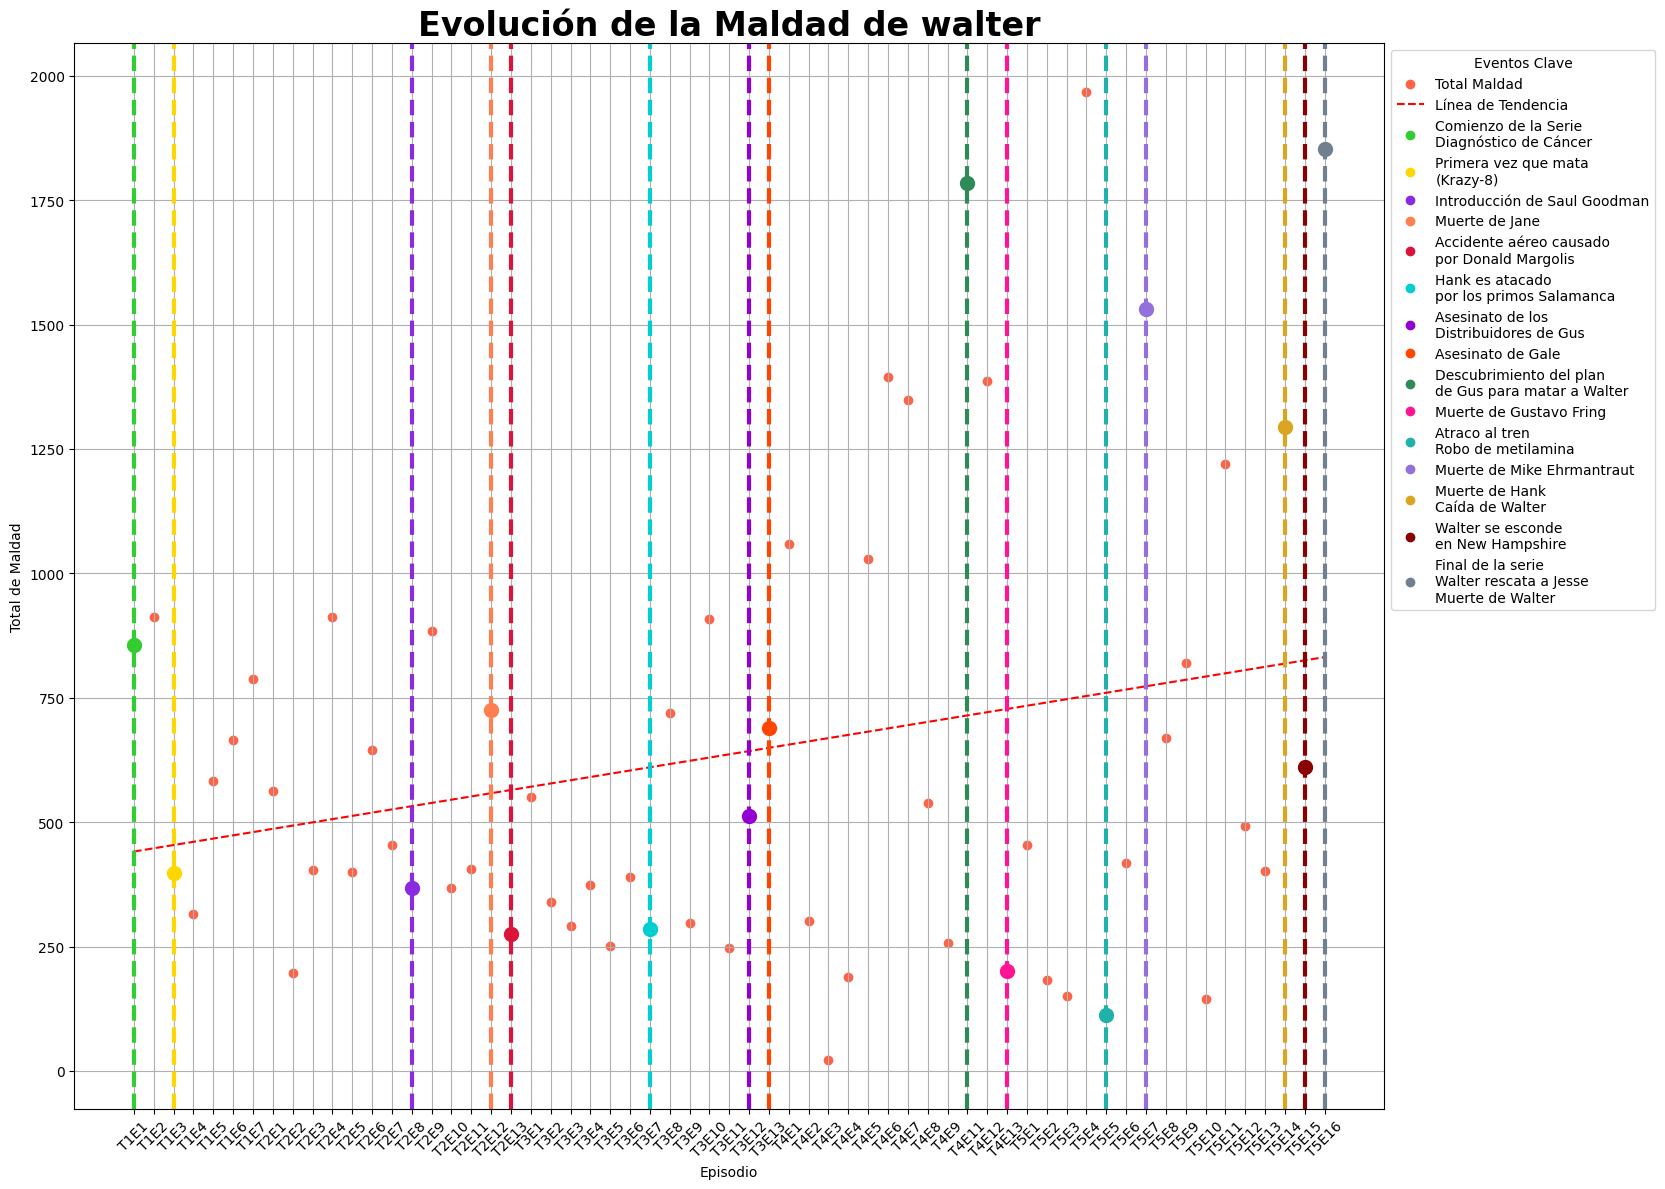

In [125]:
character_name = 'walter'
totales_por_episodio = analizar_personaje(df, character_name, metrics_columns, key_events)
plot_tendencia_evil(totales_por_episodio, character_name, key_events, event_colors)

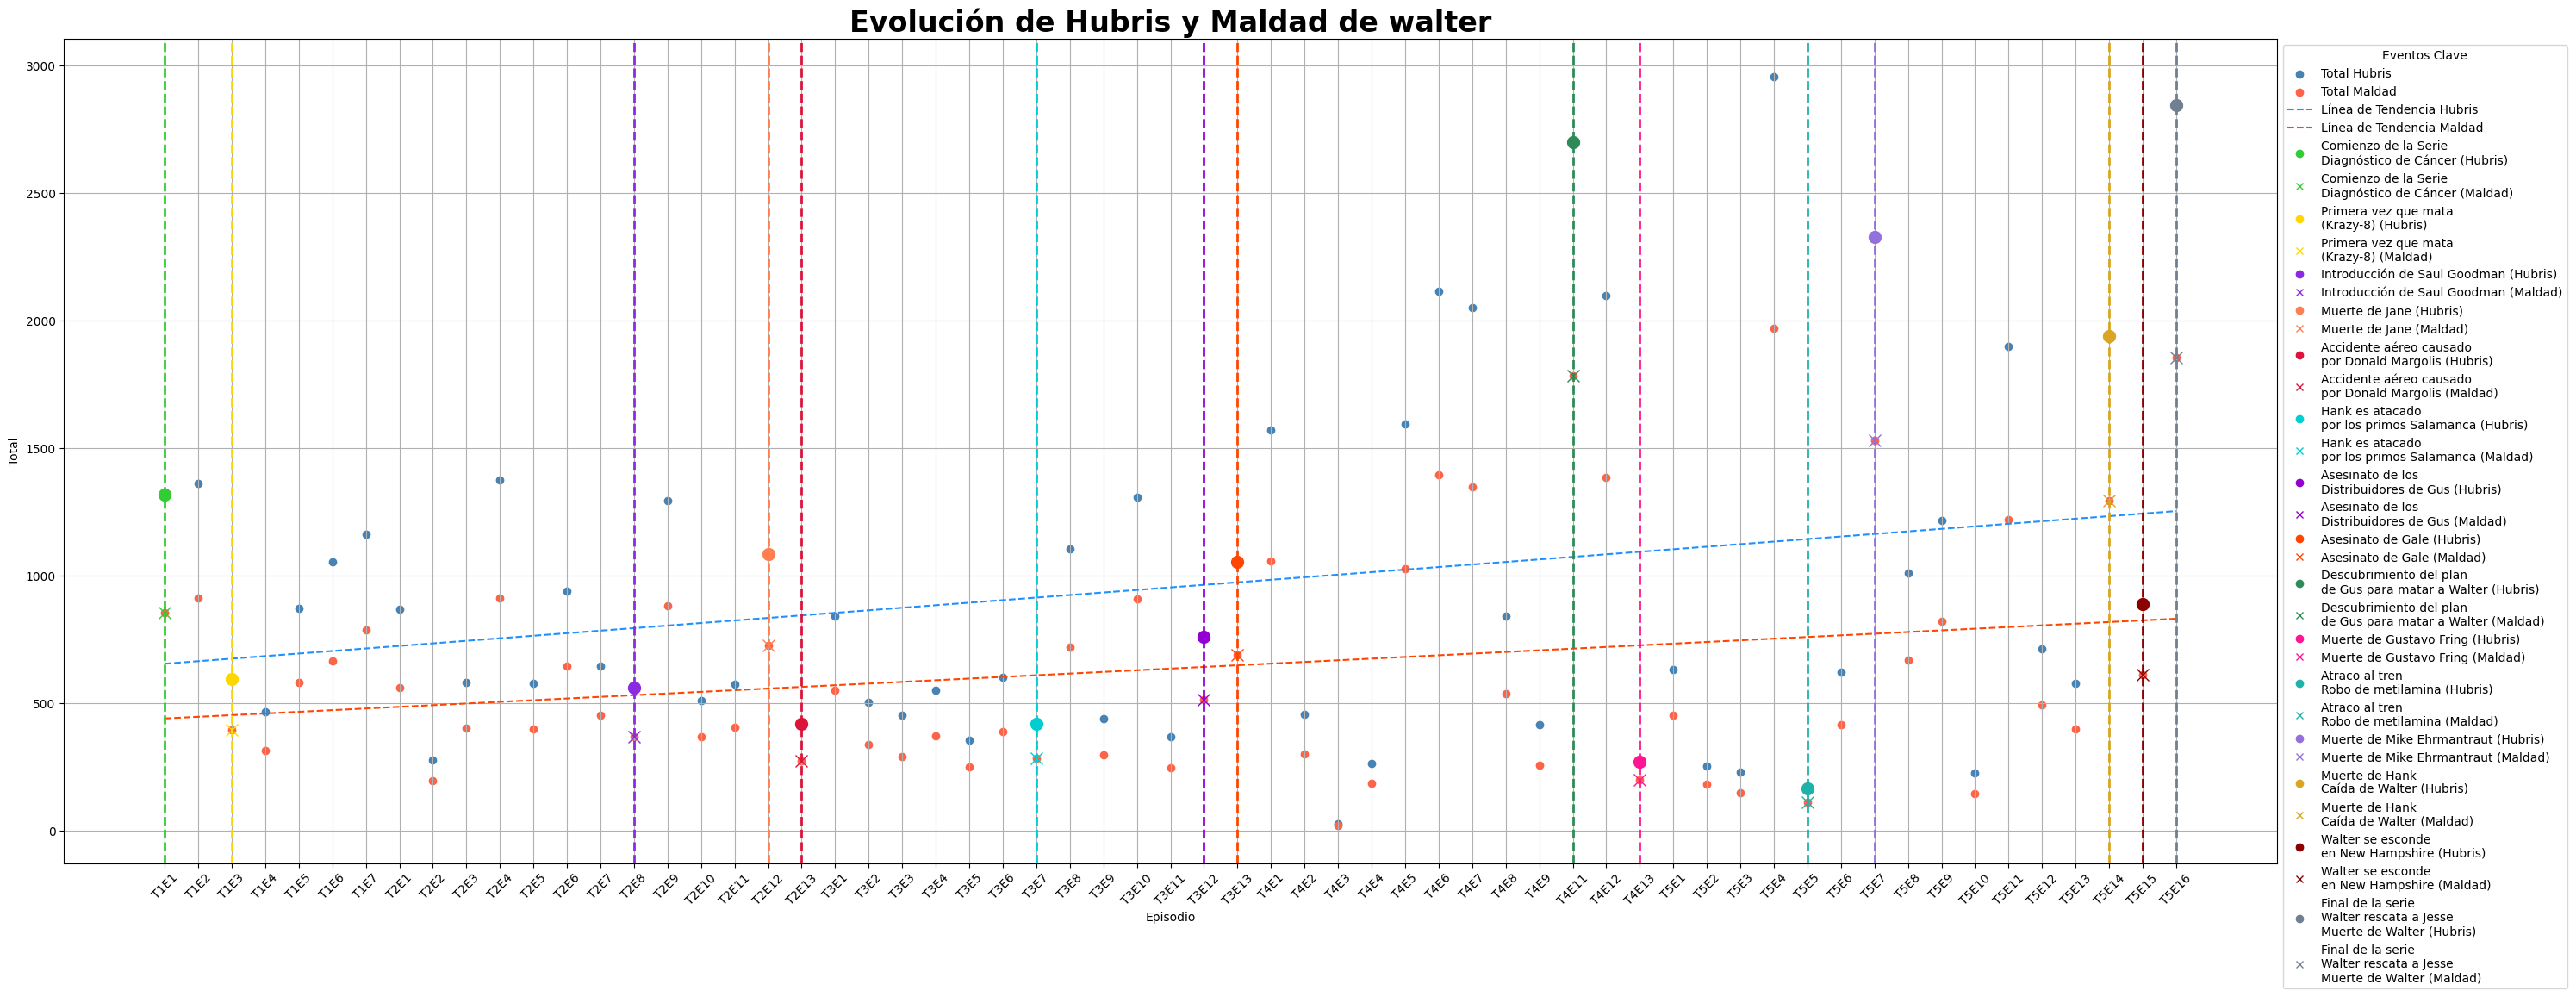

In [126]:
plot_tendencia_combined(totales_por_episodio, character_name, key_events, event_colors)

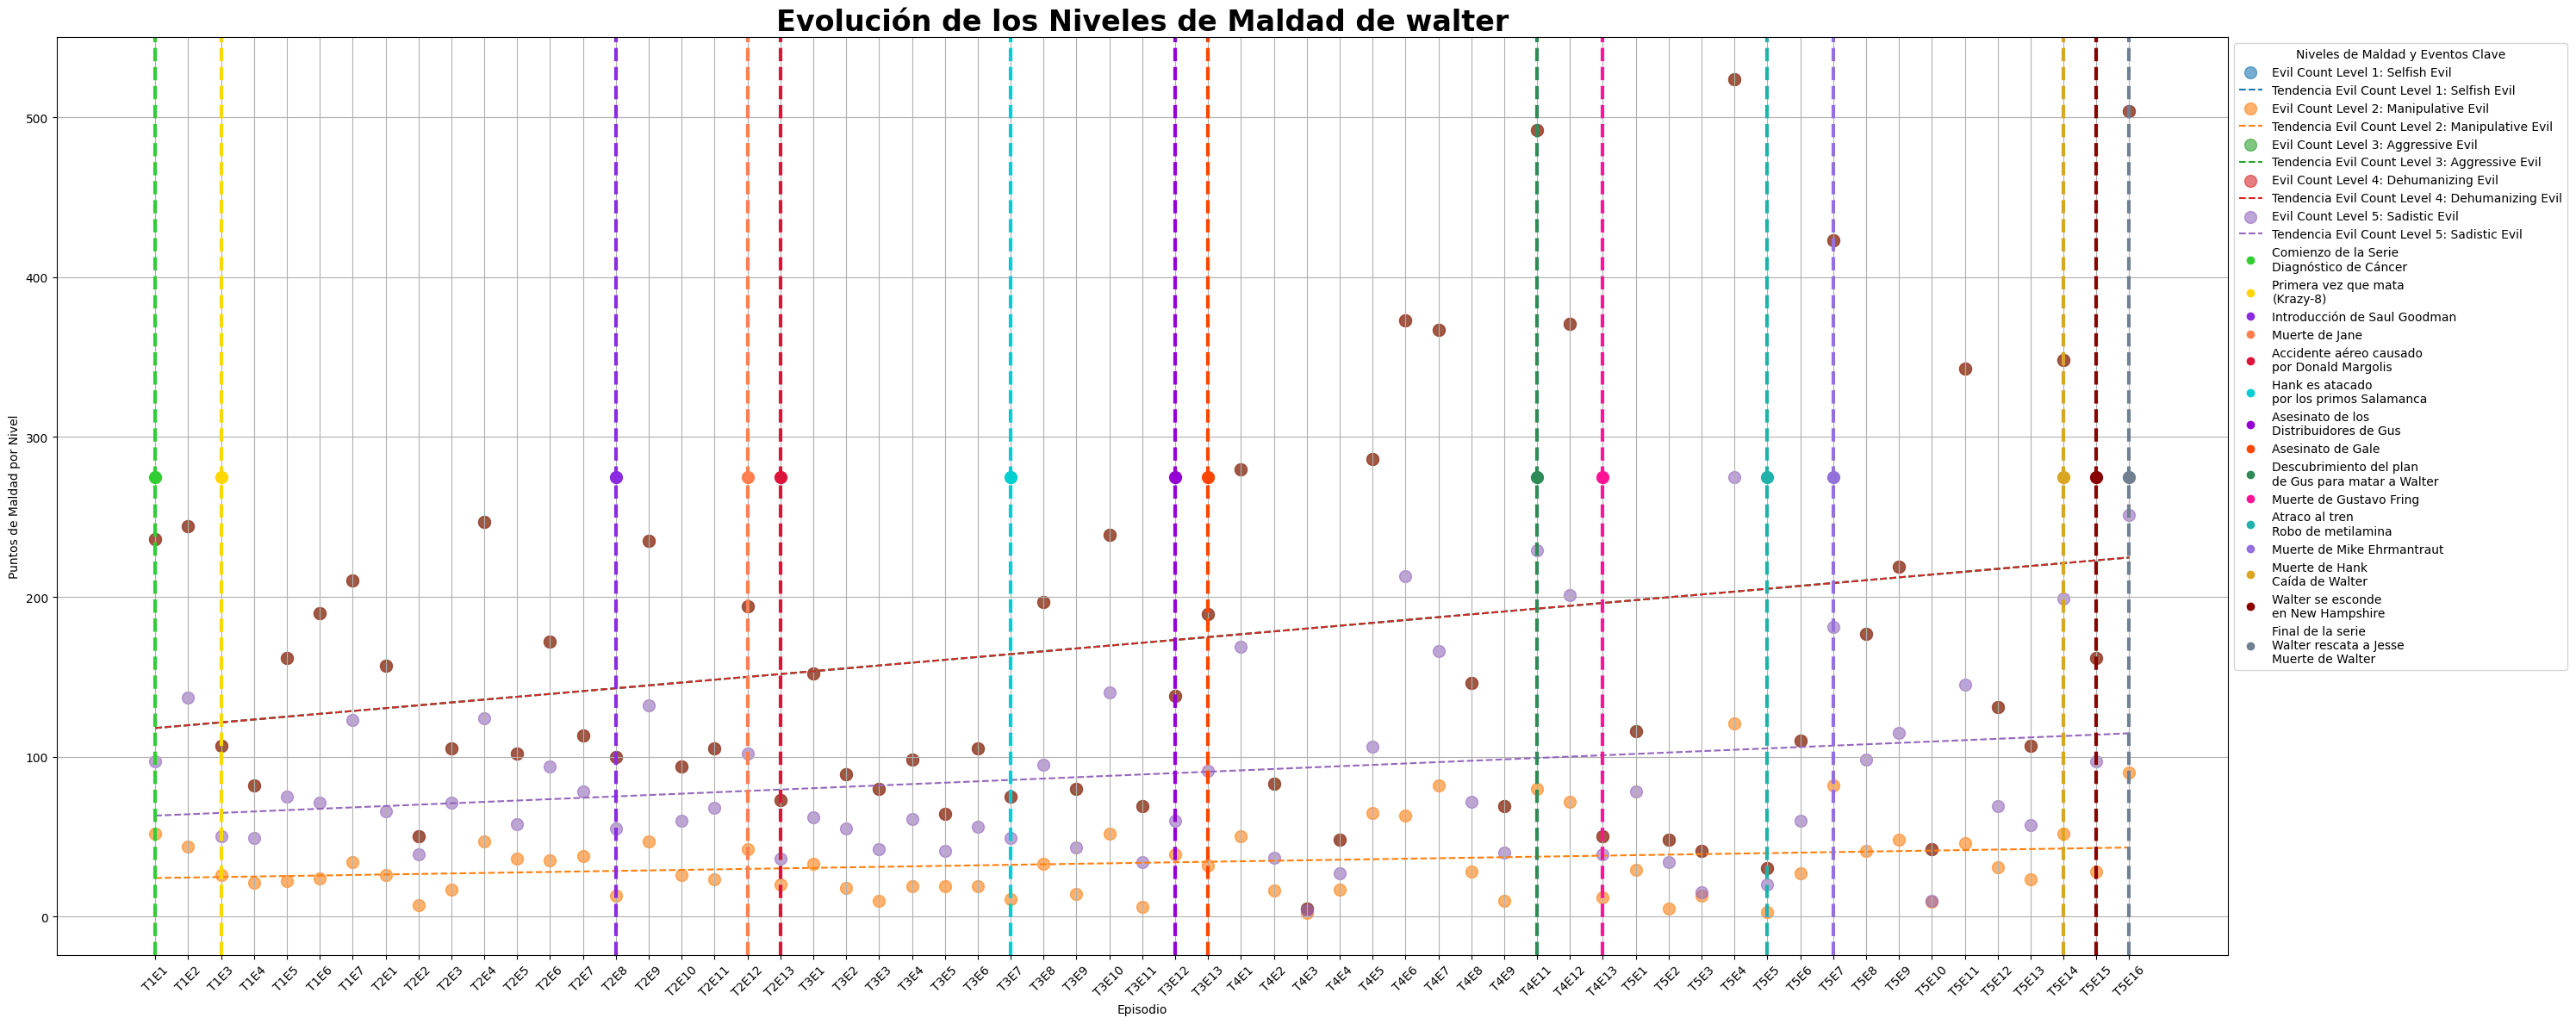

In [127]:
plot_evolucion_niveles_maldad(totales_por_episodio, character_name, key_events, event_colors)

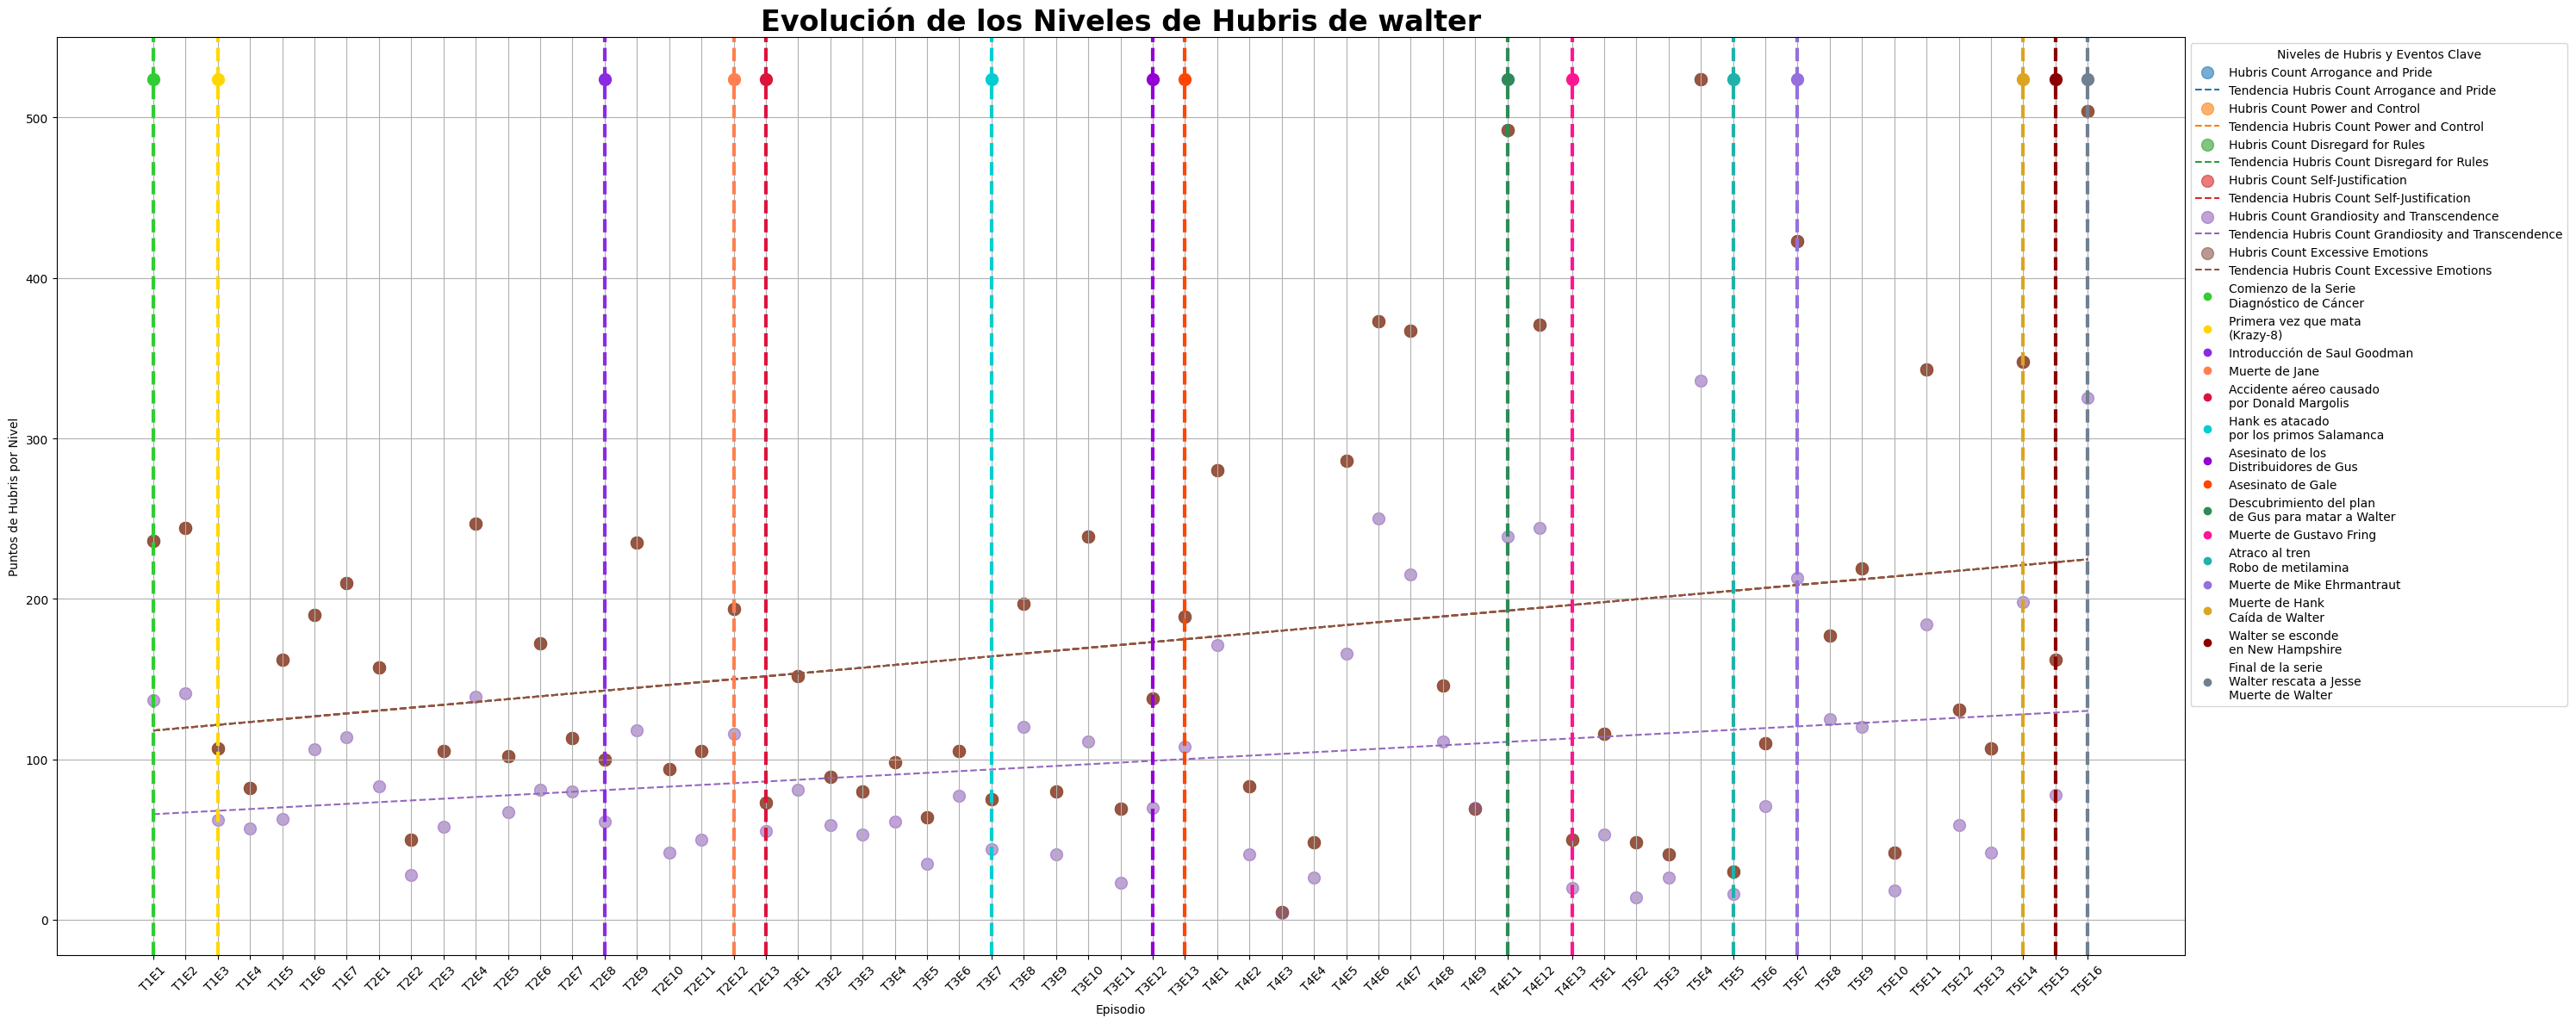

In [128]:
plot_evolucion_niveles_hubris(totales_por_episodio, character_name, key_events, event_colors)

##### Realización de gráficas de evolución de Jesse, Skyler y Mike para comparar los resultados

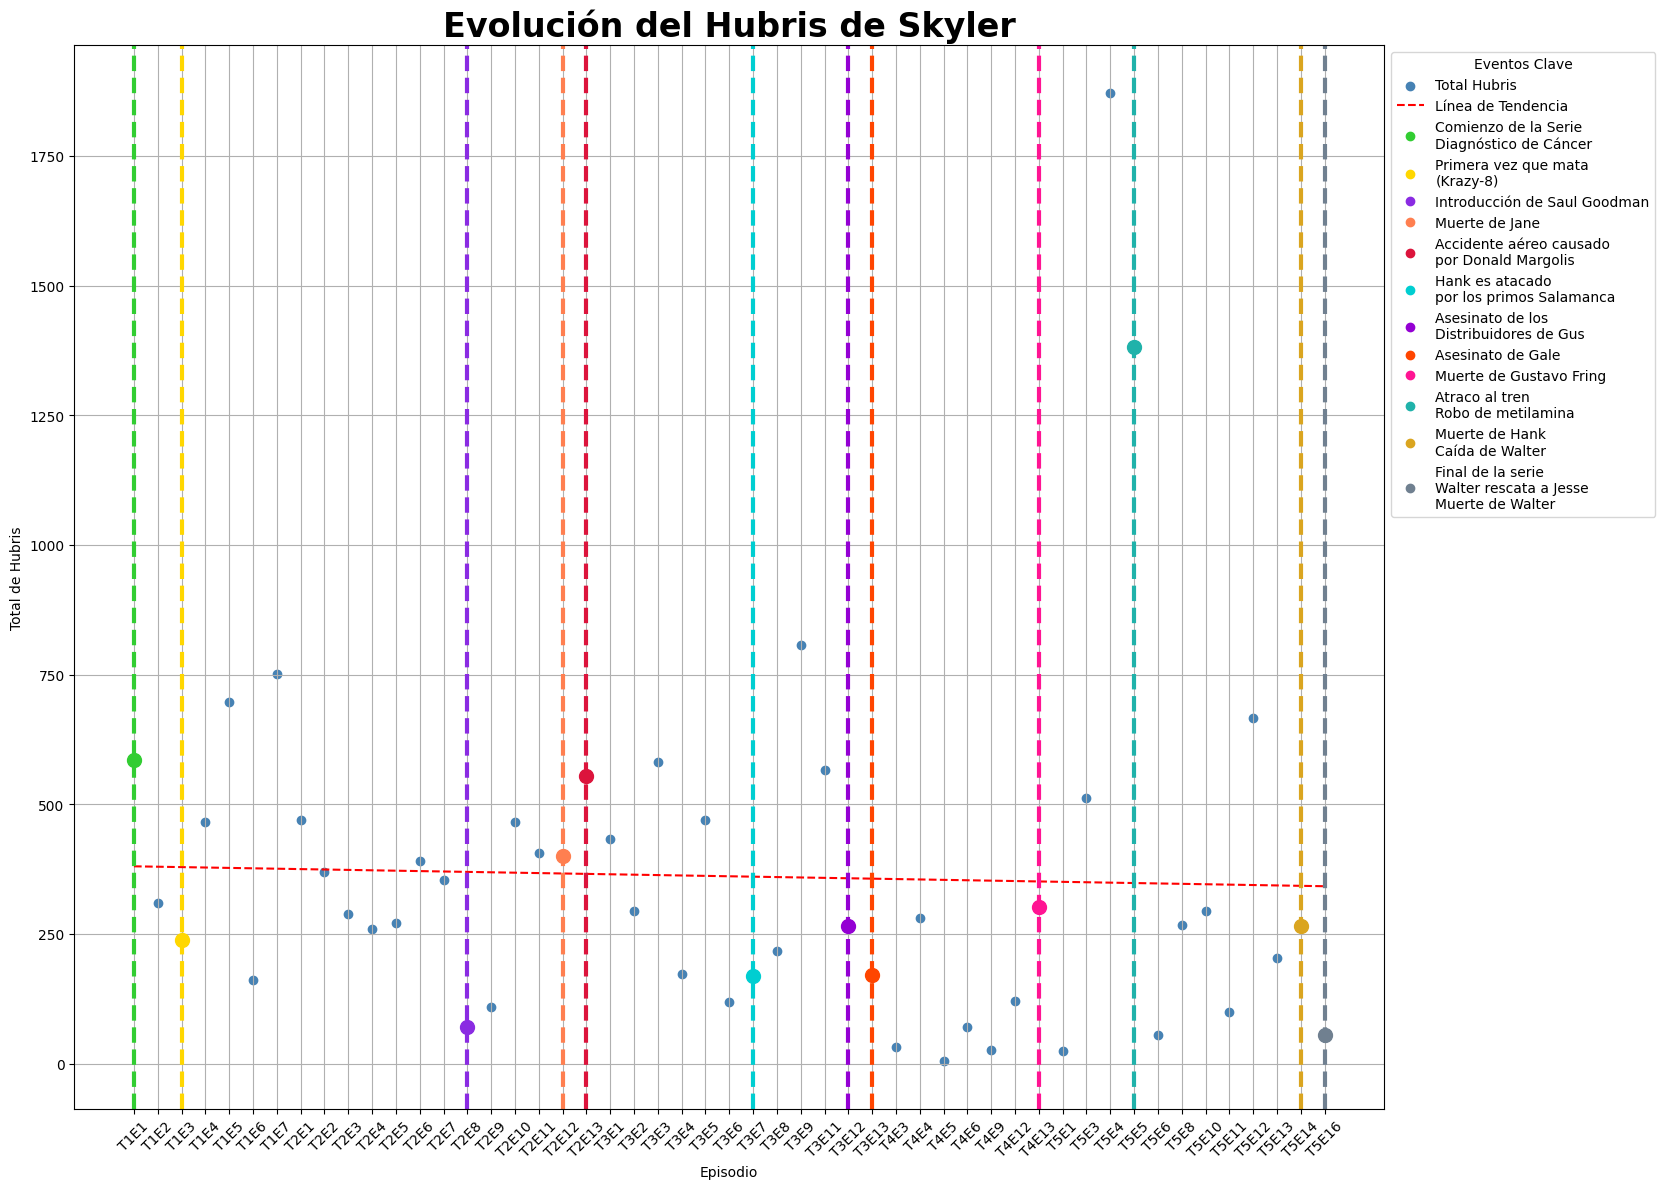

In [129]:
character_name = 'Skyler'
totales_por_episodio = analizar_personaje(df, character_name, metrics_columns, key_events)
plot_tendencia_hubris(totales_por_episodio, character_name, key_events, event_colors)

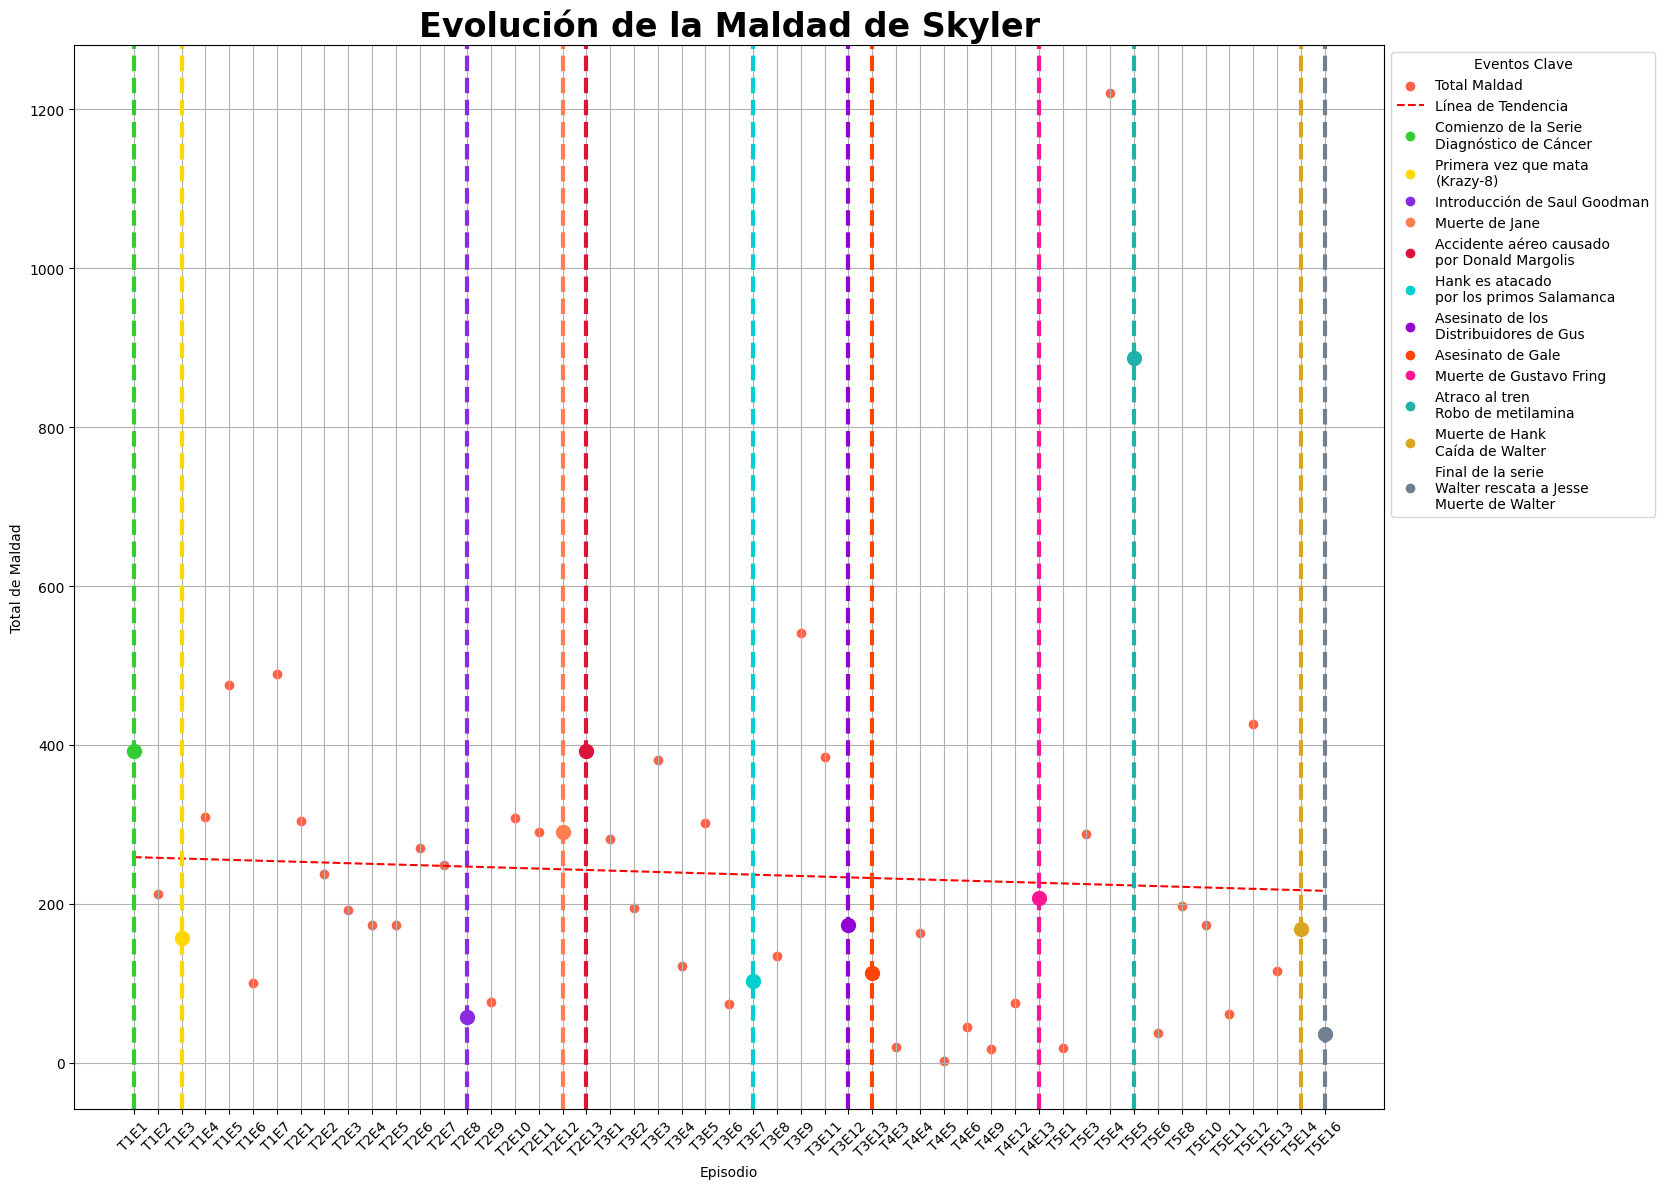

In [130]:
character_name = 'Skyler'
totales_por_episodio = analizar_personaje(df, character_name, metrics_columns, key_events)
plot_tendencia_evil(totales_por_episodio, character_name, key_events, event_colors)

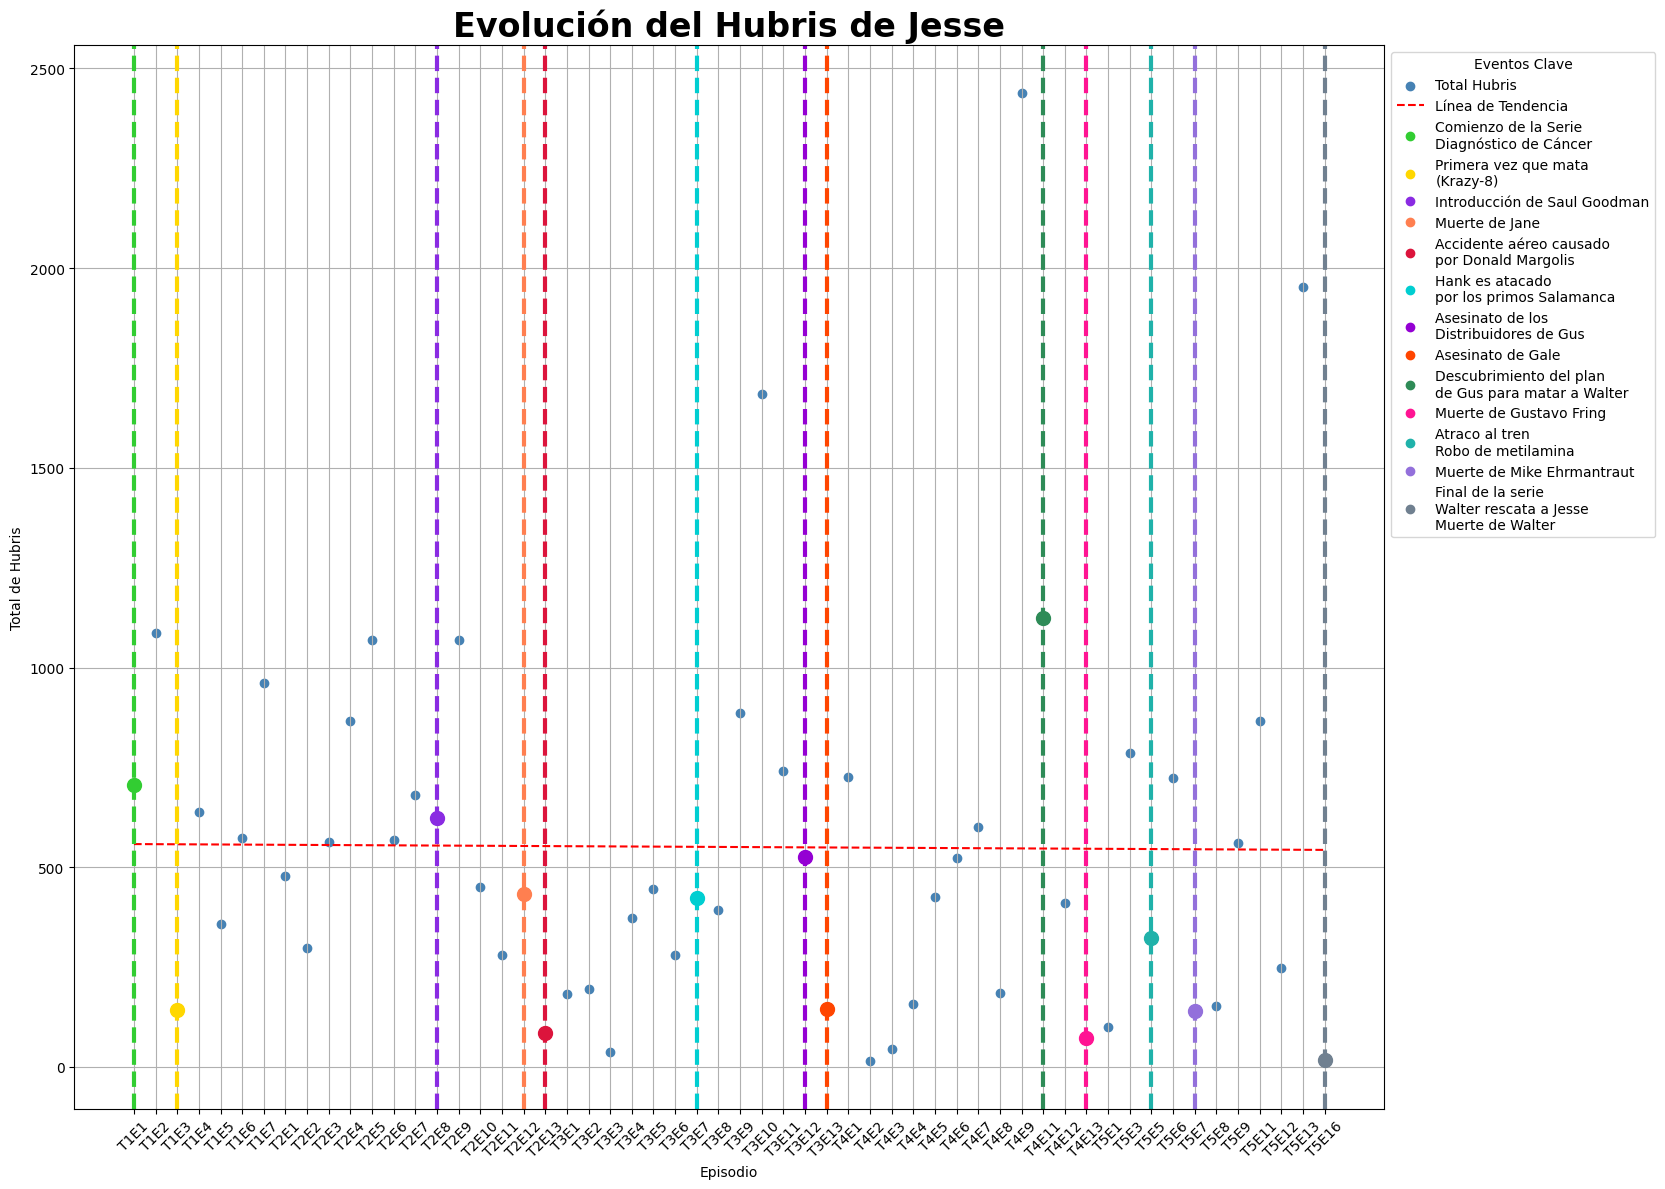

In [131]:
character_name = 'Jesse'
totales_por_episodio = analizar_personaje(df, character_name, metrics_columns, key_events)
plot_tendencia_hubris(totales_por_episodio, character_name, key_events, event_colors)

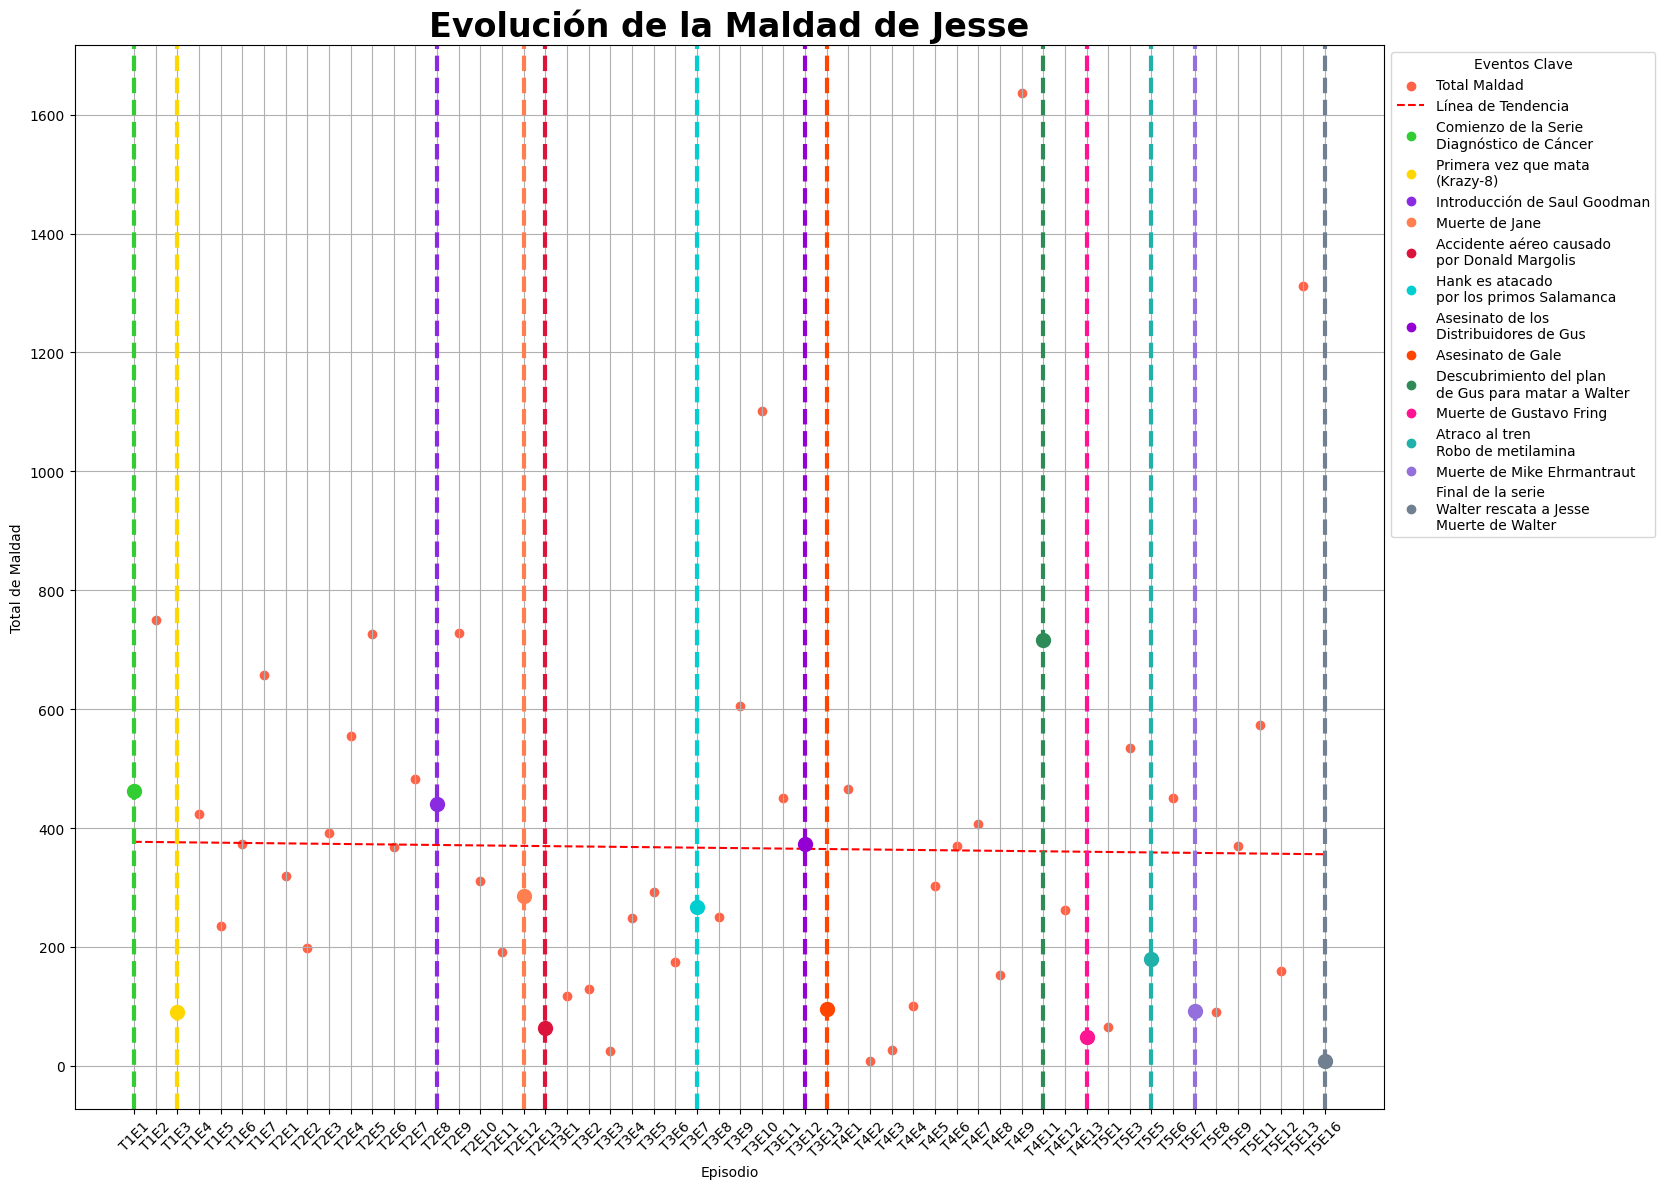

In [132]:
character_name = 'Jesse'
totales_por_episodio = analizar_personaje(df, character_name, metrics_columns, key_events)
plot_tendencia_evil(totales_por_episodio, character_name, key_events, event_colors)

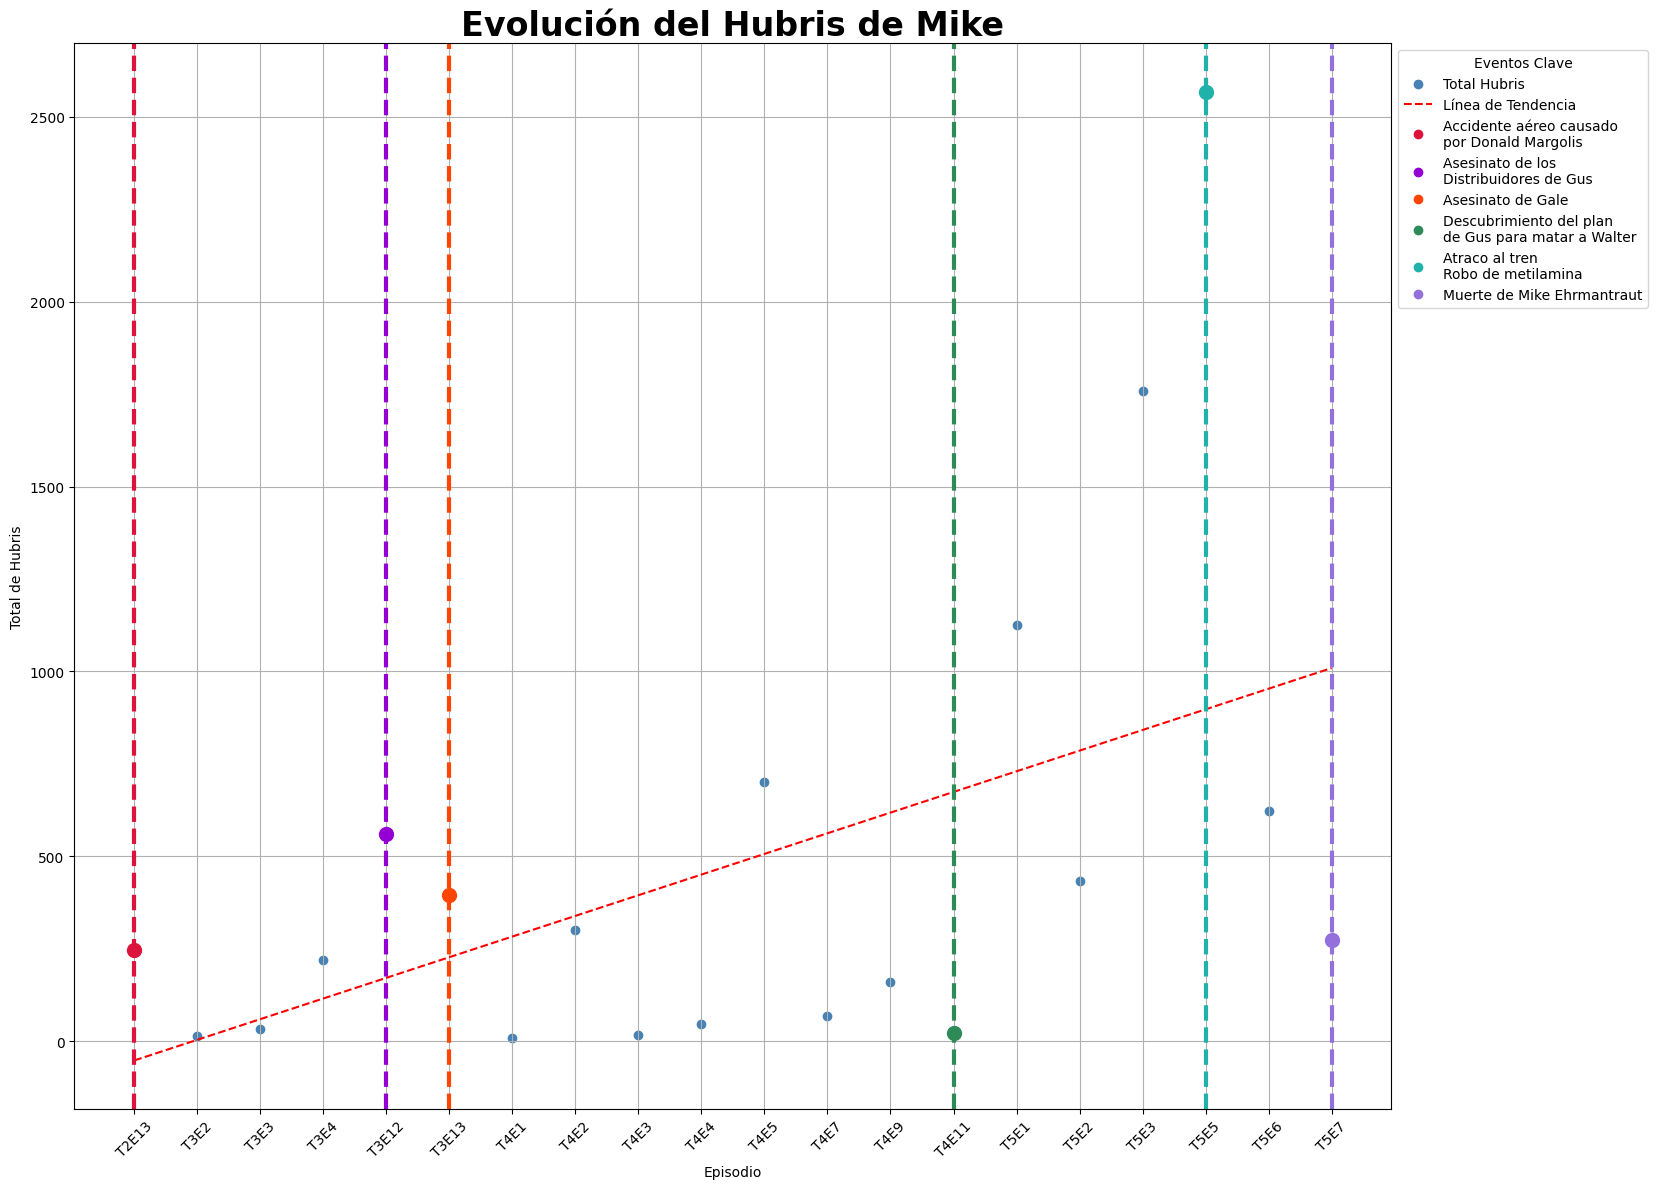

In [133]:
character_name = 'Mike'
totales_por_episodio = analizar_personaje(df, character_name, metrics_columns, key_events)
plot_tendencia_hubris(totales_por_episodio, character_name, key_events, event_colors)

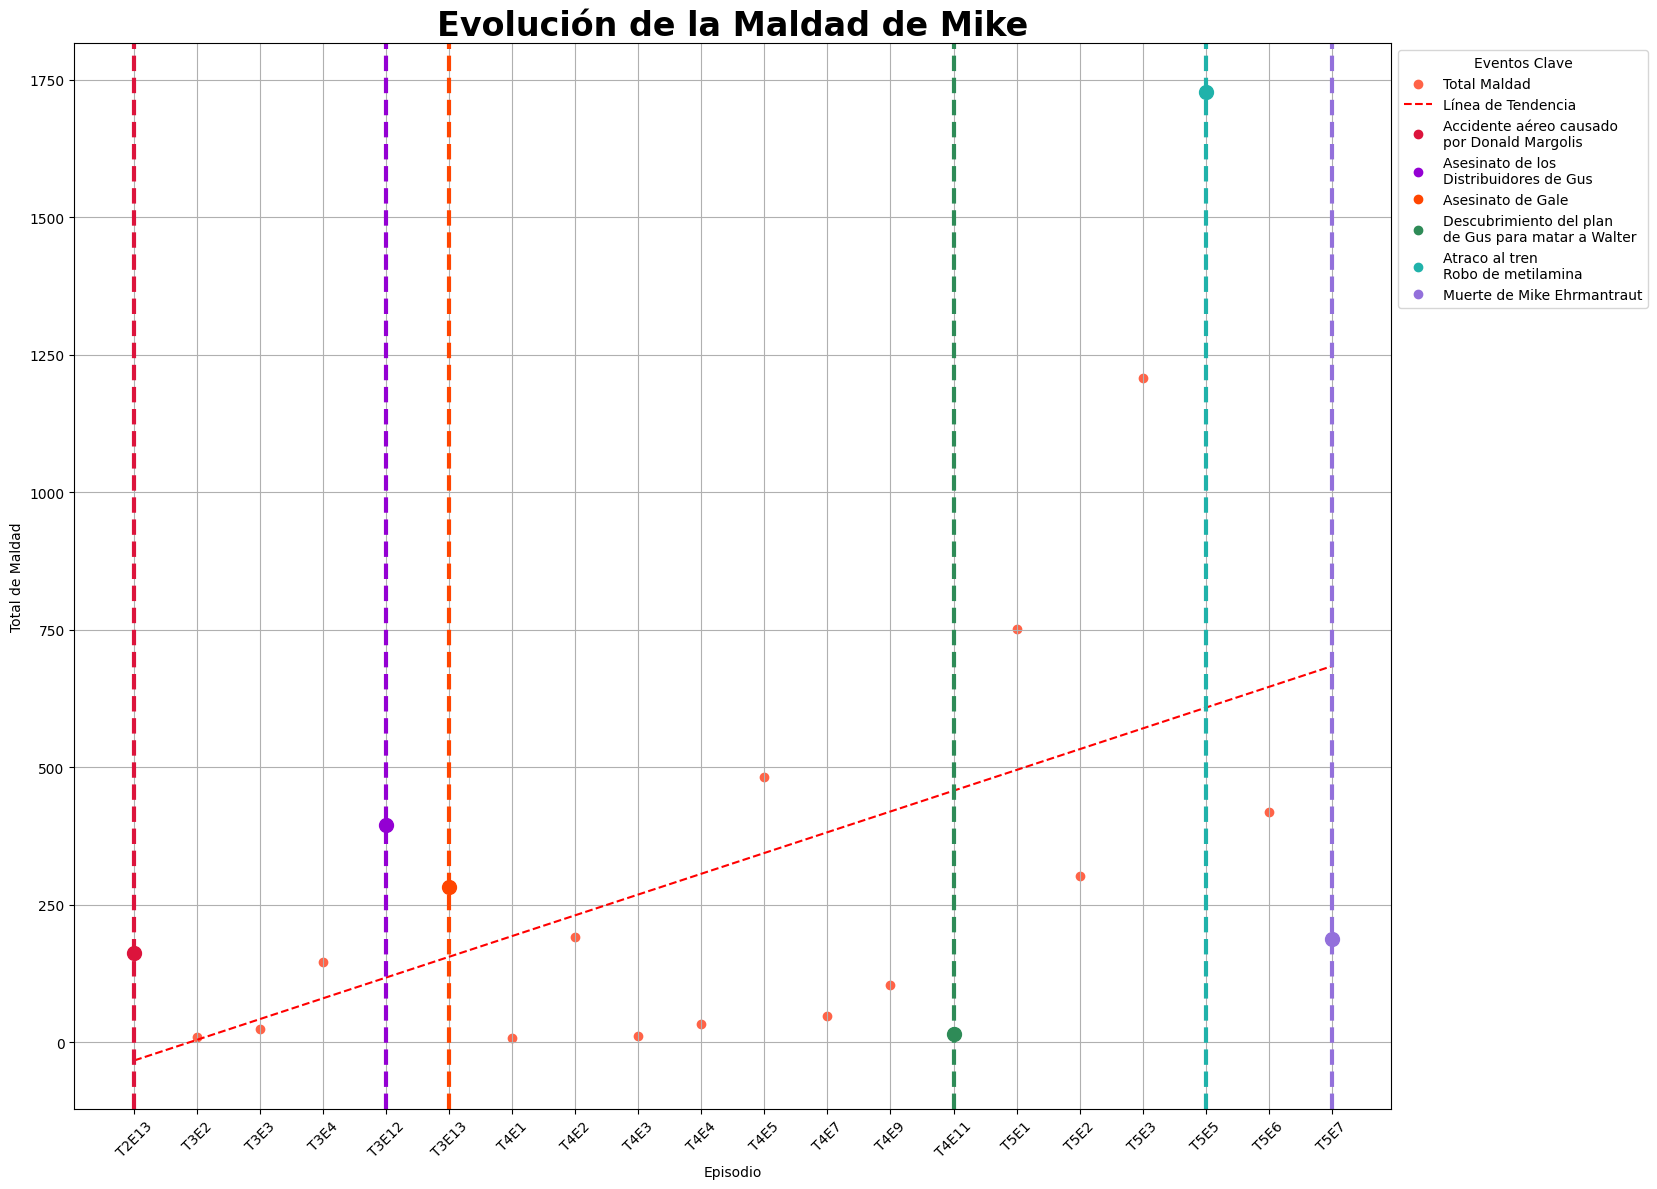

In [134]:
character_name = 'Mike'
totales_por_episodio = analizar_personaje(df, character_name, metrics_columns, key_events)
plot_tendencia_evil(totales_por_episodio, character_name, key_events, event_colors)

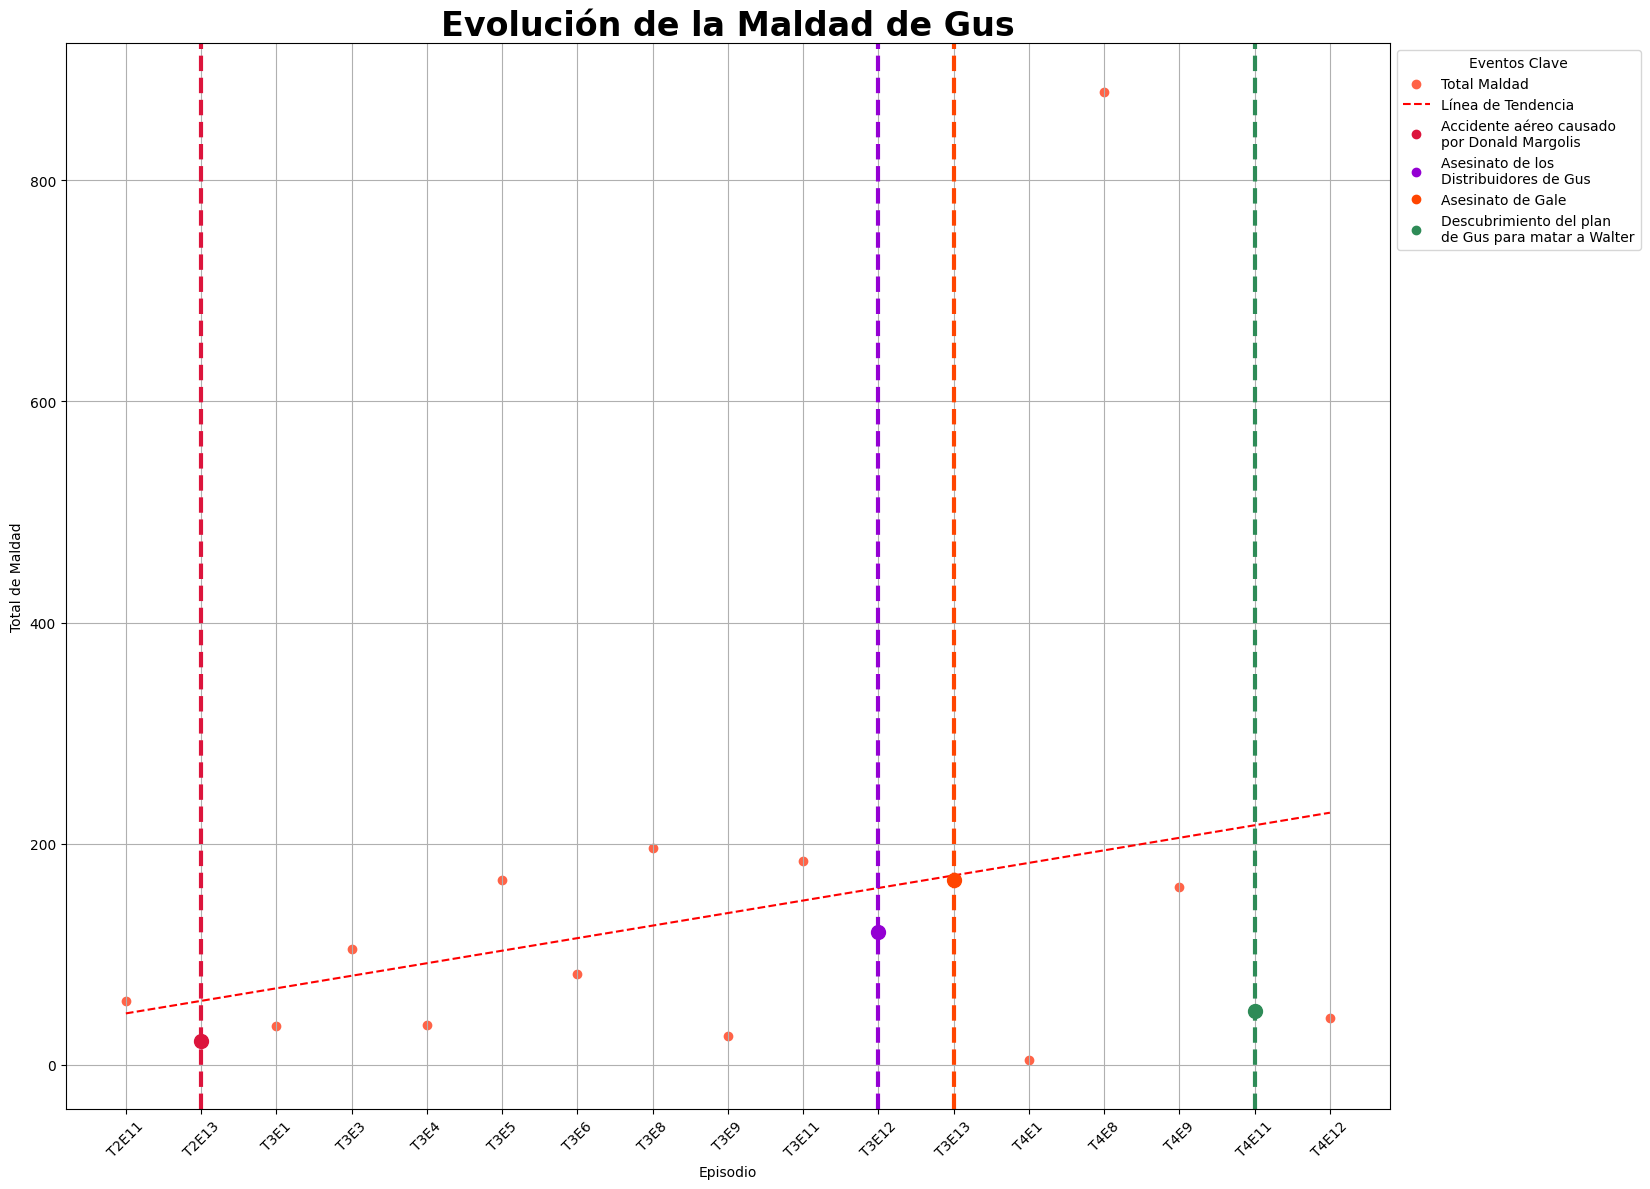

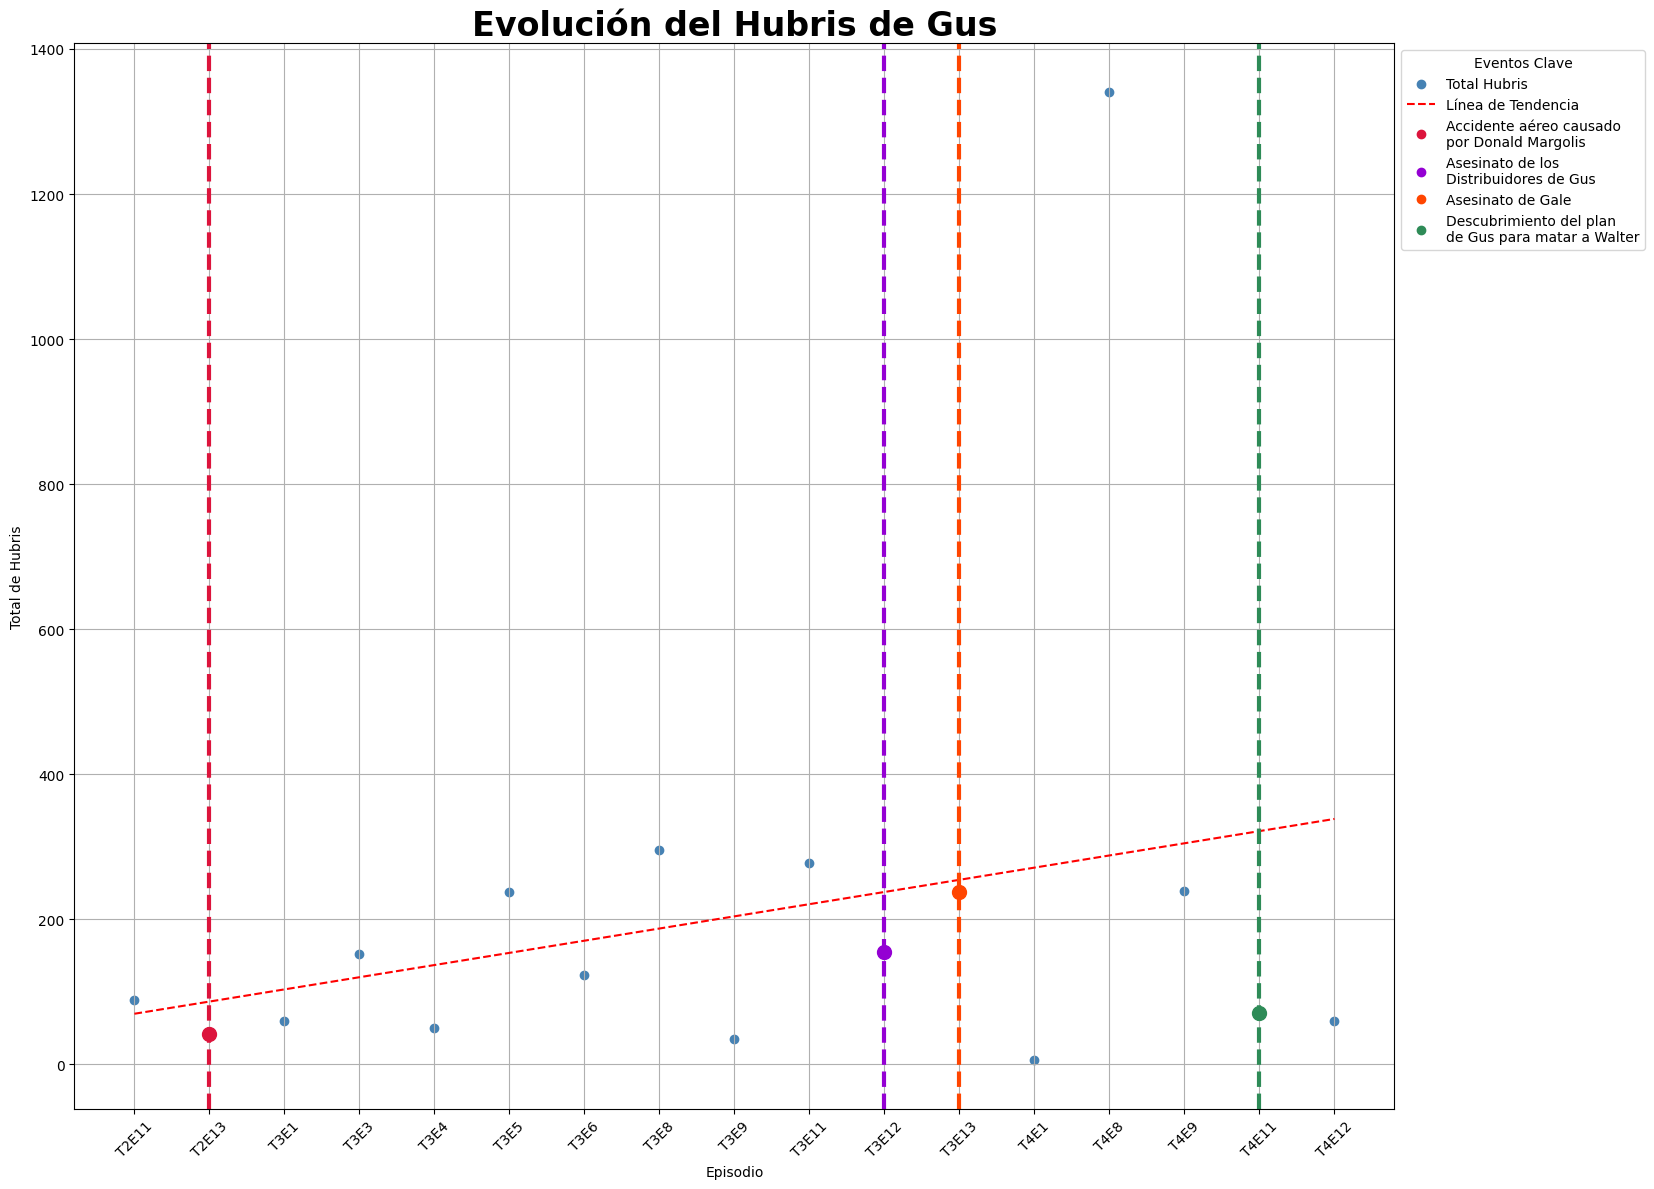

In [135]:
character_name = 'Gus'
totales_por_episodio = analizar_personaje(df, character_name, metrics_columns, key_events)
plot_tendencia_evil(totales_por_episodio, character_name, key_events, event_colors)
plot_tendencia_hubris(totales_por_episodio, character_name, key_events, event_colors)